In [23]:
import os
import pandas as pd
import json
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from collections import defaultdict
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import scipy.stats as st
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar, Table
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint


import itertools

In [24]:
# ESAP questions with images
q_w_images = [3, 4, 6, 32, 35, 54, 68, 88]

cases = np.delete(np.arange(100), [0] + q_w_images) # valid questions
n_cases = cases.size

# Available options
options = ['A', 'B', 'C', 'D', 'E']
# even for the experiments without letter, manual annotator saved the option using letter.

path_to_results = "./../results"

model_file_name_dict = {'huatuo-o1': 'HuatuoGPT-o1',
                        'diabetica-o1': 'Diabetica-o1',
                        'diabetica-7B': 'Diabetica-7B',
                        'meditron3-8B': 'Meditron3-8B'}

In [25]:
def evaluate_response_distrib(filepath):
    """ 
    Given the excel file, this function parses and standardize the file entries.
    Returns a counter in the form of a dictionary.
    """
    df_ = pd.read_excel(filepath, header=None, index_col=0)
    
    # everything capital
    df_ = df_.map(lambda x: x.upper() if isinstance(x, str) else x) 
    
    # remove NaN values - this remove extra-columns
    df_ = df_.dropna(axis=1, how='all') 
    if not np.array_equal(df_.index, cases): # we keep all 91 cases
        raise ValueError("We are removing a valid case by mistake! Check Excel file")

    # unique annotations
    # print(df_.values)
    print(np.unique(df_.values))
    unique_elements = np.unique(df_.values) 

    # multiple options selected
    # are indicated as option1-option2: there is a dash
    bm_multiple = ["-" in v_ for v_ in unique_elements] 
    
    bm_hall_none = [True if (v_ == "HALL" or v_ == 'NONE') # hallucination or no response
                    else False for v_ in unique_elements]
    
    bm_others = ~np.logical_or(bm_multiple, bm_hall_none) # correct answers / check (temporary)
    
    idx_multiple = np.where(bm_multiple)[0] # indexes
    idx_hall_none = np.where(bm_hall_none)[0]
        
    dct_counter = {}
    all_ = 0 # to make sure we did not miss any response (91 or multiple for 10 rep)

    # we are creating a new label for multi and hall/none
    if len(idx_multiple) > 0:
        count = 0
        for v_ in unique_elements[idx_multiple]:
            count += (df_.values == v_).sum()
        all_ = count
        dct_counter["MULTI"] = count
            
    if len(idx_hall_none) > 0:
        count = 0
        for v_ in unique_elements[idx_hall_none]:
            count += (df_.values == v_).sum()
        all_ += count
        dct_counter["HALL / NONE"] = count
       
    # we are using the old label for everything else
    for element in unique_elements[bm_others]:
        count = (df_.values == element).sum()
        dct_counter[element] = count
        all_ += count
            
    list_add = ["CHECK", "MULTI", "HALL / NONE", "A", "B", "C", "D", "E"]
    for el_ in list_add:
        if el_ not in dct_counter.keys():
            dct_counter[el_] = 0
    dct_counter["TOTAL"] = all_
        
    return dct_counter

# Experiment 1: Check Performance & Results

Filenames for LLMs' outputs under prompt 1 and prompt 2.

In [26]:
model_paths_token = {'meditron3-8B-prompt1': 'meditron3-8B_promptID_001_output_4.xlsx',
                     'huatuo-o1-prompt1': 'huatuo-o1_promptID_001_output_9.xlsx',
                     'huatuo-o1-prompt2': 'huatuo-o1_promptID_002_output_11.xlsx',
                     'diabetica-o1-prompt1': 'diabetica-o1_promptID_001_output_2.xlsx',
                     'diabetica-o1-prompt2': 'diabetica-o1_promptID_002_output_3.xlsx',
                     'diabetica-7B-prompt1': 'diabetica-7B_promptID_001_output_3.xlsx',
                     'diabetica-7B-prompt2': 'diabetica-7B_promptID_002_output_4.xlsx',
                     'medfound7B-prompt1': 'medfound7B_promptID_001_output_2.xlsx',
                     'medfound7B-prompt2': 'medfound7B_promptID_002_output_3.xlsx',
                     'clinical-chatgpt-prompt1': 'clinical-chatgpt_promptID_001_output_2.xlsx',
                     'clinical-chatgpt-prompt2': 'clinical-chatgpt_promptID_002_output_3.xlsx'
                    }

model_paths_no_token = {'huatuo-o1': 'huatuo-o1_promptID_001_output_47.xlsx',
                        'diabetica-o1': 'diabetica-o1_promptID_001_output_40.xlsx',
                        'diabetica-7B': 'diabetica-7B_promptID_001_output_47.xlsx',
                        'meditron3-8B': 'meditron3-8B_promptID_001_output_39.xlsx',
                        'clinical-chatgpt': 'clinical-chatgpt_promptID_001_output_4.xlsx',
                        'medfound7B': 'medfound7B_promptID_001_output_4.xlsx'
                       }

### **Function to read excel and count entries**

In [27]:
def counter_extensive_dfs(result_folder, dct_models, letter=True):
    """ 
    Used in experiment 1 to a) keep track of distribution of responses
    b) build dataframe with extensive results.
    
    Variables: 
    result_folder: str, folder containing model's output
    dct_models: str, excel file 
    letter: bool, if True, ESAP question, otherwise, letter removed from option
    
    Returns:
    df_counter: pd.DataFrame, distribution of models responses
    df_all: pd.DataFrame extensive (91 outputs)
    """
    list_df = []
    index = []
    counting_outputs = []

    for model_, file_ in dct_models.items():
        if letter:
            filepath = join(path_to_results, model_.split("-prompt")[0], file_)
        else: 
            filepath = join(path_to_results, "NO_LETTERS", file_)
            
        df_ = pd.read_excel(filepath, header=None, index_col=0)
        df_ = df_[1] # we keep first column, others are empty
        list_df.append(df_)
        
        dct_counter = evaluate_response_distrib(filepath)
        counting_outputs.append([dct_counter[k] for k in sorted(dct_counter.keys())])

    # this is for the counter
    columns_name = sorted(dct_counter.keys())
    list_model_name = [m_ if letter else f"{m_}_no_letter" for m_ in dct_models.keys()]
    df_counter = pd.DataFrame(data=counting_outputs, 
                              index=list_model_name,
                              columns=columns_name)

    # this is for the Df with 91 responses
    df_all = pd.concat(list_df, axis=1)
    df_all.columns = list_model_name
    
    return df_counter, df_all

In [28]:
df_counter_prompt_A_B, df_all = counter_extensive_dfs(path_to_results, model_paths_token)

['A' 'B' 'C' 'D' 'E' 'NONE']
['A' 'B' 'C' 'D' 'E']
['A' 'B' 'C' 'D' 'E']
['A' 'B' 'C' 'D' 'E']
['A' 'B' 'C' 'D' 'E']
['A' 'B' 'C' 'D' 'E' 'HALL']
['A' 'B' 'C' 'D' 'E']
['A' 'A-B' 'A-C' 'B' 'C' 'D' 'E' 'HALL' 'NONE']
['A' 'B' 'C' 'D' 'HALL' 'NONE']
['A' 'A-B-C-D-E' 'B' 'C' 'D' 'D-E' 'E' 'HALL' 'NONE']
['A' 'A-B' 'A-B-C-D-E' 'A-C' 'B' 'C' 'D' 'E' 'NONE']


In [29]:
df_counter_no_let, df_all_no_let = counter_extensive_dfs(path_to_results, model_paths_no_token, letter=False)

['A' 'B' 'C' 'C-D' 'D' 'E' 'NONE']
['A' 'A-B' 'B' 'C' 'C-D' 'D' 'E' 'HALL' 'NONE']
['A' 'A-B' 'B' 'B-C' 'C' 'C-D' 'C-E' 'D' 'E' 'HALL' 'NONE']
['A' 'A-B' 'B' 'B-D' 'C' 'D' 'E' 'HALL' 'NONE']
['A' 'A-E' 'B' 'C' 'D' 'E' 'HALL' 'NONE']
['A' 'A-B-C' 'A-B-C-D-E' 'A-E' 'B' 'C' 'D' 'E' 'HALL' 'NONE']


In [30]:
os.makedirs("tables", exist_ok=True)
# pd.concat([df_counter_prompt_A_B, df_counter_no_let]).to_latex("tables/readings_experiment_1.tex")

In [31]:
# concatenate all results from experiment 1
df_all = pd.concat([df_all, df_all_no_let], axis=1)

Loading ground-truth responses from ESAP, after being manually converted into json file.

In [32]:
with open("./../inference/Ped-ESAP.json", "r") as f:
    content = json.load(f)
    
responses = []
labs = []
table = []
for k, v in content.items():
    if len(v['answer']) > 0:
        responses.append(v['answer'][0])
        labs.append(v["labs"]=='Yes')
        table.append(v["table"]=='Yes')
    else:
        responses.append(None)
        labs.append(None)
        table.append(None)
        
ground_truth = pd.DataFrame(data=np.array(responses[:-1]).reshape(-1,1), index=np.arange(1,100),
                           columns=["truth"])
ground_truth = ground_truth.drop(q_w_images)

meta_labs_table = np.hstack((np.array(labs).reshape(-1,1), np.array(table).reshape(-1,1)))
meta_labs_tab_df = pd.DataFrame(data=meta_labs_table[:-1, :], index=np.arange(1,100),
                    columns=["labs", "table"])
meta_labs_tab_df = meta_labs_tab_df.drop(q_w_images)

In [33]:
meta_labs_tab_df[meta_labs_tab_df["table"]]

,labs,table
9,True,True
24,True,True
36,True,True
73,False,True


Ground truth is concatenated to table as last column.

In [34]:
# run only once, otherwise we get multiple "truth" columns
df_all = pd.concat([df_all, ground_truth], axis=1)

In [35]:
# here we keep the value in entry if is one among A, B, C, D, or E
# we report as NaN otherwise
for col in df_all.columns[:-1]:
    df_all[col] = df_all[col].where(df_all[col].isin(options), np.nan)

In [36]:
df_all.head()

,meditron3-8B-prompt1,huatuo-o1-prompt1,huatuo-o1-prompt2,diabetica-o1-prompt1,diabetica-o1-prompt2,diabetica-7B-prompt1,diabetica-7B-prompt2,medfound7B-prompt1,medfound7B-prompt2,clinical-chatgpt-prompt1,clinical-chatgpt-prompt2,huatuo-o1_no_letter,diabetica-o1_no_letter,diabetica-7B_no_letter,meditron3-8B_no_letter,clinical-chatgpt_no_letter,medfound7B_no_letter,truth
1,B,B,B,B,B,NaN,D,NaN,NaN,B,C,B,C,D,B,D,NaN,B
2,A,C,A,A,E,D,D,NaN,NaN,D,D,C,A,D,NaN,D,NaN,A
5,A,C,A,B,C,C,B,NaN,NaN,A,A,B,B,B,B,A,NaN,C
7,C,E,E,C,C,D,A,NaN,NaN,D,A,A,E,A,E,D,NaN,A
8,A,A,A,A,C,C,C,NaN,NaN,A,A,A,B,NaN,A,A,NaN,E


In [37]:
bm_valid = ~df_all.isna()

In [38]:
accuracy_df = df_all[df_all.columns[:-1]].eq(df_all['truth'], axis=0)

accuracy_df.head()

,meditron3-8B-prompt1,huatuo-o1-prompt1,huatuo-o1-prompt2,diabetica-o1-prompt1,diabetica-o1-prompt2,diabetica-7B-prompt1,diabetica-7B-prompt2,medfound7B-prompt1,medfound7B-prompt2,clinical-chatgpt-prompt1,clinical-chatgpt-prompt2,huatuo-o1_no_letter,diabetica-o1_no_letter,diabetica-7B_no_letter,meditron3-8B_no_letter,clinical-chatgpt_no_letter,medfound7B_no_letter
1,True,True,True,True,True,False,False,False,False,True,False,True,False,False,True,False,False
2,True,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False
5,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,True,False,False,False,True,True,False,True,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


We sum each column to obtain the accuracy score.

In [39]:
accuracy_scores = accuracy_df.sum()

In [40]:
models_col = df_all.columns[:-1] # we exclude the truth column

We call interpretable the case where a model is able to give a unique answer, which is one of the options specified by ESAP.

#### Double checking - the number in the following table corresponds with the more extensive ones in the article (Appendix)

In [41]:
results = pd.concat([accuracy_scores[models_col], bm_valid[models_col].sum()], axis=1)
results.columns = ['# correct', '# interpretable']

In [42]:
results/n_cases

,# correct,# interpretable
meditron3-8B-prompt1,0.329670,0.978022
huatuo-o1-prompt1,0.351648,1.000000
huatuo-o1-prompt2,0.351648,1.000000
diabetica-o1-prompt1,0.329670,1.000000
diabetica-o1-prompt2,0.340659,1.000000
diabetica-7B-prompt1,0.296703,0.989011
diabetica-7B-prompt2,0.318681,1.000000
medfound7B-prompt1,0.043956,0.186813
medfound7B-prompt2,0.120879,0.384615
clinical-chatgpt-prompt1,0.197802,0.791209


In [43]:
groups = {}
for m_ in model_paths_no_token.keys():
    groups[f"{m_}_prompt"] = [f"{m_}-prompt1", f"{m_}-prompt2"]
    groups[f"{m_}_token"] = [f"{m_}-prompt1", f"{m_}_no_letter"]
groups

{'huatuo-o1_prompt': ['huatuo-o1-prompt1', 'huatuo-o1-prompt2'],
 'huatuo-o1_token': ['huatuo-o1-prompt1', 'huatuo-o1_no_letter'],
 'diabetica-o1_prompt': ['diabetica-o1-prompt1', 'diabetica-o1-prompt2'],
 'diabetica-o1_token': ['diabetica-o1-prompt1', 'diabetica-o1_no_letter'],
 'diabetica-7B_prompt': ['diabetica-7B-prompt1', 'diabetica-7B-prompt2'],
 'diabetica-7B_token': ['diabetica-7B-prompt1', 'diabetica-7B_no_letter'],
 'meditron3-8B_prompt': ['meditron3-8B-prompt1', 'meditron3-8B-prompt2'],
 'meditron3-8B_token': ['meditron3-8B-prompt1', 'meditron3-8B_no_letter'],
 'clinical-chatgpt_prompt': ['clinical-chatgpt-prompt1',
  'clinical-chatgpt-prompt2'],
 'clinical-chatgpt_token': ['clinical-chatgpt-prompt1',
  'clinical-chatgpt_no_letter'],
 'medfound7B_prompt': ['medfound7B-prompt1', 'medfound7B-prompt2'],
 'medfound7B_token': ['medfound7B-prompt1', 'medfound7B_no_letter']}

In [44]:
def bootstrap_kappa(x, y, B=10000, n=n_cases):
    # bootstrap for Cohen's coefficient confidence intervals
    rng = np.random.default_rng(seed=np.random.choice(100000))
    idx = np.arange(n)
    kappas = []
    for b in range(B): 
        I = rng.choice(idx, len(idx), True)
        tmp_agreement_mask = (x == y) & x.notna() & y.notna()
        tmp_n_agree = tmp_agreement_mask.iloc[I].sum()
        kappas.append((tmp_n_agree/n-0.2)/0.8)
    lo, hi = np.percentile(kappas, [2.5, 97.5])
    return lo, hi


accuracy_when_agree = {}

    
for model, cols in groups.items():
    if len(cols) == 2:
        col1, col2 = cols
        if not (col1 in df_all.columns and col2 in df_all.columns):
            continue
            
        # Keep rows where both predictions agree and are not NaN
        agreement_mask = (df_all[col1] == df_all[col2]) & df_all[col1].notna() & df_all[col2].notna()
        agreed_preds = df_all.loc[agreement_mask, col1]
        truths = df_all.loc[agreement_mask, 'truth']
        x, y = df_all[col1], df_all[col2]
        low, high = bootstrap_kappa(x, y)
        # Calculate accuracy where predictions agree
        acc = (agreed_preds == truths).sum()
        accuracy_when_agree[model] = {
            "n_agreements": agreement_mask.sum(),
            "# match & correct": acc,
            "bootstrap CI": (low, high)
        }

# Display results
for model, stats in accuracy_when_agree.items():
    lo, hi = proportion_confint(stats['n_agreements'], n_cases, method="wilson")
    print(f"""{model.upper()}\n
    {stats['n_agreements']} agreements, 
    # match & correct = {stats['# match & correct']:.3f}, 
    match-rate = {stats['n_agreements']/n_cases:.2f}, 95% CI [{lo:.2f}, {hi:.2f}],
    Cohen's coef = {(stats['n_agreements']/n_cases-0.2)/0.8},
    Bootstrap CI Cohen's = {stats['bootstrap CI']}\n\n""")

HUATUO-O1_PROMPT

    58 agreements, 
    # match & correct = 23.000, 
    match-rate = 0.64, 95% CI [0.53, 0.73],
    Cohen's coef = 0.5467032967032966,
    Bootstrap CI Cohen's = (np.float64(0.423076923076923), np.float64(0.6703296703296704))


HUATUO-O1_TOKEN

    44 agreements, 
    # match & correct = 19.000, 
    match-rate = 0.48, 95% CI [0.38, 0.58],
    Cohen's coef = 0.35439560439560436,
    Bootstrap CI Cohen's = (np.float64(0.23076923076923078), np.float64(0.47802197802197804))


DIABETICA-O1_PROMPT

    47 agreements, 
    # match & correct = 17.000, 
    match-rate = 0.52, 95% CI [0.42, 0.62],
    Cohen's coef = 0.39560439560439564,
    Bootstrap CI Cohen's = (np.float64(0.27197802197802196), np.float64(0.5192307692307693))


DIABETICA-O1_TOKEN

    44 agreements, 
    # match & correct = 16.000, 
    match-rate = 0.48, 95% CI [0.38, 0.58],
    Cohen's coef = 0.35439560439560436,
    Bootstrap CI Cohen's = (np.float64(0.23076923076923078), np.float64(0.49175824175824173))

In [45]:
def count_ci(k, n=n_cases):
    lo, hi = proportion_confint(k, n, method="wilson")
    return pd.Series({
        "acc": k / n,
        "lo_prop": lo,
        "hi_prop": hi,
        "lo_count": lo * n,
        "hi_count": hi * n
    })

new = results["# correct"].copy()
# Apply across the DataFrame
new = new.apply(count_ci)

# Combine back with your model labels
df_ci = pd.concat([results, new], axis=1)
df_ci

,# correct,# interpretable,acc,lo_prop,hi_prop,lo_count,hi_count
meditron3-8B-prompt1,30,89,0.329670,0.241709,0.431430,21.995519,39.260105
huatuo-o1-prompt1,32,91,0.351648,0.261373,0.453942,23.784923,41.308685
huatuo-o1-prompt2,32,91,0.351648,0.261373,0.453942,23.784923,41.308685
diabetica-o1-prompt1,30,91,0.329670,0.241709,0.431430,21.995519,39.260105
diabetica-o1-prompt2,31,91,0.340659,0.251514,0.442713,22.887746,40.286870
diabetica-7B-prompt1,27,90,0.296703,0.212635,0.397240,19.349776,36.148872
diabetica-7B-prompt2,29,91,0.318681,0.231960,0.420091,21.108360,38.228272
medfound7B-prompt1,4,17,0.043956,0.017224,0.107631,1.567417,9.794415
medfound7B-prompt2,11,35,0.120879,0.068855,0.203615,6.265813,18.528964
clinical-chatgpt-prompt1,18,72,0.197802,0.128945,0.291140,11.733959,26.493762


In the following, we show the case index where we had agreement across prompt A, prompt B, and prompt A without letter token.

In [46]:
for m_ in model_paths_no_token.keys():
    acc_pmt1 = np.where(accuracy_df[f'{m_}-prompt1'])[0]
    acc_no_let = np.where(accuracy_df[f'{m_}_no_letter'])[0]
    if m_ != 'meditron3-8B':
        acc_pmt2 = np.where(accuracy_df[f'{m_}-prompt2'])[0]
        print(m_)
        print(sorted(list((set(acc_pmt2).intersection(set(acc_pmt1))).intersection(set(acc_no_let)))))
        print("\n")

huatuo-o1
[np.int64(0), np.int64(6), np.int64(8), np.int64(21), np.int64(24), np.int64(38), np.int64(40), np.int64(54), np.int64(55), np.int64(56), np.int64(65), np.int64(68), np.int64(69), np.int64(71), np.int64(75), np.int64(83), np.int64(90)]


diabetica-o1
[np.int64(6), np.int64(20), np.int64(24), np.int64(40), np.int64(50), np.int64(59), np.int64(62), np.int64(68), np.int64(69), np.int64(77), np.int64(89), np.int64(90)]


diabetica-7B
[np.int64(6), np.int64(15), np.int64(19), np.int64(22), np.int64(34), np.int64(35), np.int64(40), np.int64(55), np.int64(59), np.int64(62), np.int64(68), np.int64(69), np.int64(83), np.int64(85), np.int64(89)]


clinical-chatgpt
[np.int64(5), np.int64(23), np.int64(40), np.int64(43), np.int64(71)]


medfound7B
[np.int64(71)]




In [47]:
models = [["huatuo-o1-prompt1", "huatuo-o1-prompt2", "huatuo-o1_no_letter"],
          ["diabetica-o1-prompt1", "diabetica-o1-prompt2", "diabetica-o1_no_letter"], 
          ["diabetica-7B-prompt1", "diabetica-7B-prompt2", "diabetica-7B_no_letter"], 
          ["meditron3-8B-prompt1", "meditron3-8B_no_letter"],
          ["clinical-chatgpt-prompt1", "clinical-chatgpt-prompt2", "clinical-chatgpt_no_letter"],
          ["medfound7B-prompt1", "medfound7B-prompt2", "medfound7B_no_letter"]]

## McNemar's Test

In [48]:
# McNemar's test
def mcnemar_single(series1_bm, series2_bm): 
    x, y = series1_bm.to_numpy(), series2_bm.to_numpy()
    n10 = np.sum((x==1)&(y==0))
    n01 = np.sum((x==0)&(y==1))
    table = [[np.sum((x==0)&(y==0)), n01],
             [n10, np.sum((x==1)&(y==1))]]
    pvals = mcnemar(table, exact=True).pvalue
    return pvals

    
for cols in models: 
    pairs = list(itertools.combinations(cols, 2))
    for a, b in pairs:
        p = mcnemar_single(accuracy_df[a], accuracy_df[b])
        print(f"{a} vs {b}: p={p:.4f}")
    print("\n")

huatuo-o1-prompt1 vs huatuo-o1-prompt2: p=1.0000
huatuo-o1-prompt1 vs huatuo-o1_no_letter: p=0.8388
huatuo-o1-prompt2 vs huatuo-o1_no_letter: p=0.8318


diabetica-o1-prompt1 vs diabetica-o1-prompt2: p=1.0000
diabetica-o1-prompt1 vs diabetica-o1_no_letter: p=0.4049
diabetica-o1-prompt2 vs diabetica-o1_no_letter: p=0.3075


diabetica-7B-prompt1 vs diabetica-7B-prompt2: p=0.7539
diabetica-7B-prompt1 vs diabetica-7B_no_letter: p=0.8238
diabetica-7B-prompt2 vs diabetica-7B_no_letter: p=0.5034


meditron3-8B-prompt1 vs meditron3-8B_no_letter: p=1.0000


clinical-chatgpt-prompt1 vs clinical-chatgpt-prompt2: p=1.0000
clinical-chatgpt-prompt1 vs clinical-chatgpt_no_letter: p=1.0000
clinical-chatgpt-prompt2 vs clinical-chatgpt_no_letter: p=1.0000


medfound7B-prompt1 vs medfound7B-prompt2: p=0.0923
medfound7B-prompt1 vs medfound7B_no_letter: p=1.0000
medfound7B-prompt2 vs medfound7B_no_letter: p=0.0654




## Stuart-Maxwell Test

In [49]:
def stuart_maxwell(x, y): 
    tab = pd.crosstab(x, y)
    res = Table(tab).test_nominal_association()  # Stuart–Maxwell
    return res.statistic, res.pvalue
    
for cols in models: 
    print(cols[0].split('-prompt')[0])
    pairs = list(itertools.combinations(cols, 2))
    pvals = []
    for a,b in pairs:
        stats, pval = stuart_maxwell(df_all[a], df_all[b])
        print(f"{a} vs {b}: p={pval}")
    print("\n")

huatuo-o1
huatuo-o1-prompt1 vs huatuo-o1-prompt2: p=9.992007221626409e-16
huatuo-o1-prompt1 vs huatuo-o1_no_letter: p=2.645000279777321e-05
huatuo-o1-prompt2 vs huatuo-o1_no_letter: p=1.170857699683836e-08


diabetica-o1
diabetica-o1-prompt1 vs diabetica-o1-prompt2: p=2.421497805160655e-06
diabetica-o1-prompt1 vs diabetica-o1_no_letter: p=1.949451960669979e-05
diabetica-o1-prompt2 vs diabetica-o1_no_letter: p=4.433931888314646e-09


diabetica-7B
diabetica-7B-prompt1 vs diabetica-7B-prompt2: p=0.0
diabetica-7B-prompt1 vs diabetica-7B_no_letter: p=3.2980825848127893e-09
diabetica-7B-prompt2 vs diabetica-7B_no_letter: p=1.8207657603852567e-13


meditron3-8B
meditron3-8B-prompt1 vs meditron3-8B_no_letter: p=0.005977985631178462


clinical-chatgpt
clinical-chatgpt-prompt1 vs clinical-chatgpt-prompt2: p=0.1898673855785693
clinical-chatgpt-prompt1 vs clinical-chatgpt_no_letter: p=0.004637283163608008
clinical-chatgpt-prompt2 vs clinical-chatgpt_no_letter: p=0.342828844242973


medfound7B
medf

## Numerical Reproducibility: RTX 5090 (CUDA 12.8) and comparison against L40S (CUDA 11.8)

In [51]:
# reproducibility 

path = "./../results/MACHINE2"
model_rep = ['huatuo-o1', 'diabetica-o1', 'diabetica-7B', 'meditron3-8B']

for i_, m in enumerate(model_rep):
    tmp = pd.read_excel(os.path.join(path, f"{m}_promptID_001_output_0.xlsx"), index_col=0, header=None)
    if i_ == 0:
        df_machine2 = tmp
    else:
        df_machine2 = pd.concat([df_machine2, tmp], axis=1)
df_machine2 = pd.concat([df_machine2, df_all["truth"]], axis=1)

df_machine2.columns = [[f"{m}-prompt1" for m in model_rep] + ["truth"]]

# here we keep the value in entry if is one among A, B, C, D, or E
# we report as NaN otherwise
for col in df_machine2.columns[:-1]:
    df_machine2[col] = df_machine2[col].where(df_machine2[col].isin(options), np.nan)

for m in model_rep:
    accuracy_machine2 = df_machine2[f"{m}-prompt1"].eq(df_all['truth'], axis=0)
    print(accuracy_machine2.sum() / n_cases)

huatuo-o1-prompt1    0.395604
dtype: float64
diabetica-o1-prompt1    0.307692
dtype: float64
diabetica-7B-prompt1    0.307692
dtype: float64
meditron3-8B-prompt1    0.340659
dtype: float64


In [52]:
df_machine2

,huatuo-o1-prompt1,diabetica-o1-prompt1,diabetica-7B-prompt1,meditron3-8B-prompt1,truth
1,B,C,A,B,B
2,D,B,D,NaN,A
5,B,B,B,A,C
7,C,C,C,NaN,A
8,A,A,C,A,E
...,...,...,...,...,...
95,B,D,D,D,E
96,D,D,E,E,E
97,D,B,D,D,A
98,D,B,D,D,D


In [53]:
accuracy_when_agree = {}

models_list = [f"{m}-prompt1" for m in model_rep]
for model in models_list:
    print(model)
    # print(model)
    # Keep rows where both predictions agree and are not NaN
    count_correct = df_machine2[model].eq(df_all['truth'], axis=0).sum()

    agreement_mask = (df_all[model] == df_machine2[model].squeeze()) & df_all[model].notna() & df_machine2[model].squeeze().notna()
    agreed_preds = df_all.loc[agreement_mask, model]
    truths = df_all.loc[agreement_mask, 'truth']
    low, high = bootstrap_kappa(df_all[model], df_machine2[model].squeeze())
    # Calculate accuracy where predictions agree
    acc = (agreed_preds == truths).sum()

    pval_mcnemar = mcnemar_single(df_machine2[model].squeeze().eq(df_all['truth'], axis=0), df_all[model].eq(df_all['truth'], axis=0))
    stat, pval_stuart = stuart_maxwell(df_machine2[model].squeeze(), df_all[model])

    accuracy_when_agree[model] = {
        "n_agreements": agreement_mask.sum(),
        "accuracy": count_correct/n_cases,
        "CI accuracy":  count_ci(count_correct, n=n_cases)/ n_cases,
        "accuracy in agreement": acc,
        "bootstrap CI": (low, high),
        "p-val McNemar": pval_mcnemar,
        "Stuart-Maxwell test": (stat, pval_stuart)
        }

# Display results
for model, stats in accuracy_when_agree.items():
    lo, hi = proportion_confint(stats['n_agreements'], n_cases, method="wilson")
    print(f"""{model.upper()}\n
    {stats['n_agreements']} agreements, 
    accuracy model = {(stats['accuracy'])}, 
    CI accuracy = {stats['CI accuracy']['lo_count'], stats['CI accuracy']['hi_count']}, 
    Match rate = {stats['n_agreements']/n_cases:.2f}, 95% CI [{lo:.2f}, {hi:.2f}],
    cohens = {(stats['n_agreements']/n_cases-0.2)/0.8},
    bootstrap k = {stats['bootstrap CI']},
    p-val McNemar = {stats['p-val McNemar']},
    stats, p-val Stuart-Maxwell = {stats['Stuart-Maxwell test']}\n\n""")

huatuo-o1-prompt1
diabetica-o1-prompt1
diabetica-7B-prompt1
meditron3-8B-prompt1
HUATUO-O1-PROMPT1

    55 agreements, 
    accuracy model = huatuo-o1-prompt1    0.395604
dtype: float64, 
    CI accuracy = (huatuo-o1-prompt1    0.301332
dtype: float64, huatuo-o1-prompt1    0.498334
dtype: float64), 
    Match rate = 0.60, 95% CI [0.50, 0.70],
    cohens = 0.5054945054945054,
    bootstrap k = (np.float64(0.3818681318681318), np.float64(0.6291208791208791)),
    p-val McNemar = 0.5034446716308594,
    stats, p-val Stuart-Maxwell = (np.float64(96.03220116739136), np.float64(1.9095836023552692e-13))


DIABETICA-O1-PROMPT1

    57 agreements, 
    accuracy model = diabetica-o1-prompt1    0.307692
dtype: float64, 
    CI accuracy = (diabetica-o1-prompt1    0.222268
dtype: float64, diabetica-o1-prompt1    0.408695
dtype: float64), 
    Match rate = 0.63, 95% CI [0.52, 0.72],
    cohens = 0.532967032967033,
    bootstrap k = (np.float64(0.40934065934065933), np.float64(0.6565934065934065)),
 

# Experiment 3: Check Reasoning and Self-Evaluation

In [54]:
os.makedirs("plots", exist_ok=True)

In [55]:
physician_eval = {"huatuo-o1_promptID_001_output_9": [3, 4, 4, 4, 3, 2, 2, 3], 
                  "huatuo-o1_promptID_002_output_11": [2, 2, 2, 2],
                  "diabetica-o1_promptID_001_output_2": [],
                  "diabetica-o1_promptID_002_output_3": []}

dict_fileid = {"huatuo-o1": {1: 9,
                             2: 11},
              "diabetica-o1": {1: 2,
                               2: 3}
              }

In [56]:
contingency_table_dict = {}
# we save a contigency table with frequency of selection of ESAP vs model response

filtered_df_dict = {}
# we save dataframes whenever the model prefers its previous response over ESAP

missing_choice = {}

for model_name in dict_fileid:
    
    path_to_reasoning = join(path_to_results, "REASONING", model_name)
    contingency_table_dict[model_name] = {}
    filtered_df_dict[model_name] = {}
    missing_choice[model_name] = {}
    
    
    for prompt, file_id in dict_fileid[model_name].items():
        
        experiment_name = f"{model_name}_promptID_00{prompt}_output_{file_id}"

        list_df_esap = []
        for esap in [1, 2]: # ground truth in first or second position

            model_exp = {1: 2, 2: 1}[esap]  # model reasoning in other location
            model_and_exp_name = experiment_name.split("_output")[0]

            filename = f"reasoning_ESAP{esap}_{model_name}_{experiment_name}.xlsx"
            df_reason = pd.read_excel(join(path_to_reasoning, filename),
                          header=None, index_col=0)
            n_cols = df_reason.shape[1] 
            if n_cols >= 3: # eliminate nan columns
                df_reason = df_reason.drop([i for i in range(3, n_cols+1)], axis=1)

            df_reason.columns = [f"ESAP {esap} preferred", f"Agreement {esap}"]
            df_reason[f"ESAP {esap} preferred"] = df_reason[f"ESAP {esap} preferred"].map({esap: True, model_exp: False})
            list_df_esap.append(df_reason)
            
        df_ = pd.concat([pd.concat(list_df_esap, axis=1), accuracy_df[model_name+f"-prompt{prompt}"]], axis=1)

        # df_[df_.columns[-1]] model response from experiment 1 was correct
        df_subset = df_[~df_[df_.columns[-1]]] # model from experiment 1 was wrong

        # Drop rows where 'ESAP preferred' is NaN
        filtered_df = df_subset[(df_subset['ESAP 1 preferred'].notna()) 
                                & (df_subset['ESAP 2 preferred'].notna())]

        # Count dropped rows
        num_dropped = len(df_subset) - len(filtered_df)

        # Create contingency table
        contingency_table = pd.crosstab(filtered_df['ESAP 1 preferred'], filtered_df['ESAP 2 preferred'])
        contingency_table_dict[model_name][prompt] = contingency_table
        
        filtered_df_dict[model_name][prompt] = filtered_df
        
        # print(f"Rows with missing response in at least one of the two runs': {num_dropped}")        
        missing_choice[model_name][prompt] = num_dropped

In [57]:
def plot_boxplot_agreement_levels(dict_wrong_answers, model_name, prompt):
    filtered_df = dict_wrong_answers[model_name][prompt]
    prompt_label = ["A", "B"]

    cond1 = filtered_df['ESAP 1 preferred'].astype(bool)
    cond2 = filtered_df['ESAP 2 preferred'].astype(bool)

    nn = filtered_df[(~cond1 & ~cond2)][['Agreement 1', 'Agreement 2']].mean(axis=1)
    yy = filtered_df[(cond1 & cond2)][['Agreement 1', 'Agreement 2']].mean(axis=1)
    n1y2 = filtered_df[(~cond1 & cond2)][['Agreement 1', 'Agreement 2']].mean(axis=1)
    y1n2 = filtered_df[(cond1 & ~cond2)][['Agreement 1', 'Agreement 2']].mean(axis=1)

    boxprops = dict(linewidth=2)
    medianprops = dict(linewidth=2)
    whiskerprops = dict(linewidth=2)
    capprops = dict(linewidth=2)
    flierprops = dict(marker='o', markersize=5, linestyle='none')

    fig, ax = plt.subplots(ncols=4, sharey=True)
    ax[0].set_ylim([0,5.2])
    for a in ax:
        a.spines['bottom'].set_linewidth(3)
        a.spines['left'].set_linewidth(3)
        a.spines['top'].set_linewidth(3)
        a.spines['right'].set_linewidth(3)
        a.tick_params(width=3)

    nn.plot.box(ax=ax[3], label='ESAP\nnever',
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops,
                title=f"$n={nn.size}$", fontsize=16)

    yy.plot.box(ax=ax[0], label='ESAP\nboth',
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops,
                title=f"$n={yy.size}$", fontsize=14)
    n1y2.plot.box(ax=ax[1], label='ESAP\nsecond',
                  boxprops=boxprops, medianprops=medianprops,
                  whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops,
                  title=f"$n={n1y2.size}$", fontsize=14)
    y1n2.plot.box(ax=ax[2], label='ESAP\nfirst', 
                  boxprops=boxprops, medianprops=medianprops,
                  whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops,
                  title=f"$n={y1n2.size}$", fontsize=14)
    ax[0].set_ylabel("Agreement Level", fontsize=18)

    for i_ in range(4):
        ax[i_].set_title(ax[i_].get_title(), fontsize=16)   # increase title size


    fig.text(0.5, 0.99, f"Comparing ESAP with \nWrong Outcomes (Prompt {prompt_label[prompt-1]})", 
             ha='center', fontsize=18);

    plt.subplots_adjust(bottom=0.15, top=0.9)

    plt.tight_layout()

    fig.text(0.5, -0.05, "Picking ESAP Explanation as Best", ha='center', fontsize=20)
    # plt.savefig(f"plots/{model_name}_{prompt}_boxplot.pdf", bbox_inches='tight')
    plt.show()

huatuo-o1 for prompt 1


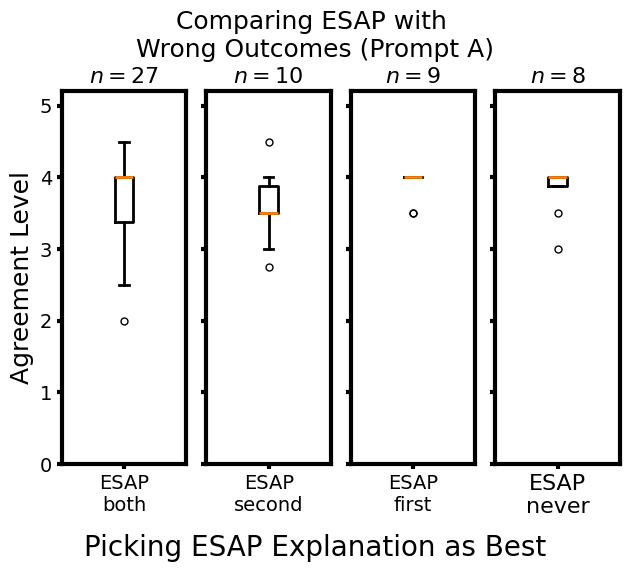

huatuo-o1 for prompt 2


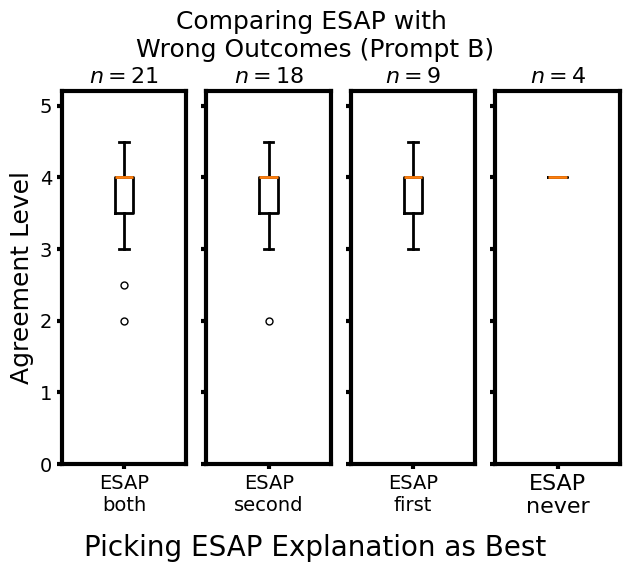

diabetica-o1 for prompt 1


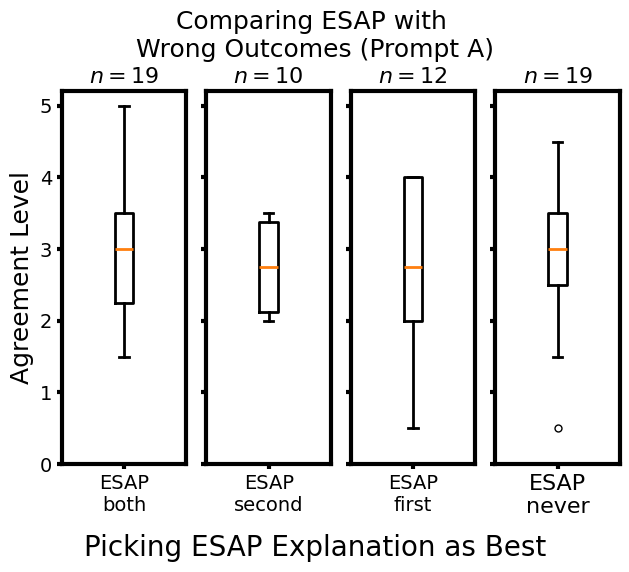

diabetica-o1 for prompt 2


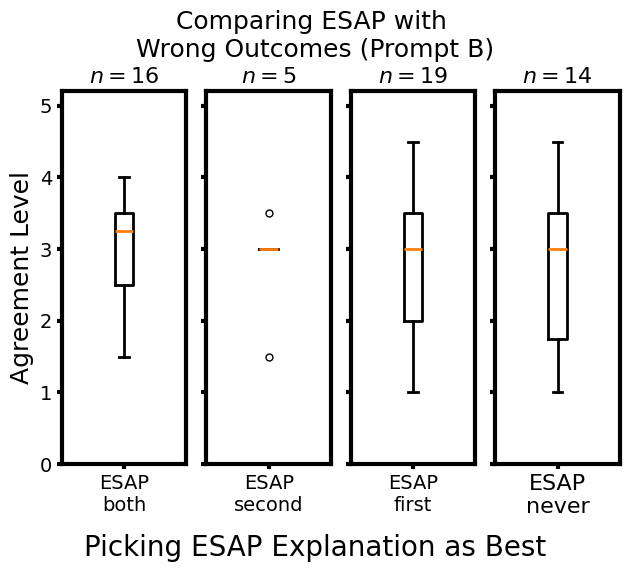

In [58]:
for model_name in dict_fileid:
    for prompt in dict_fileid[model_name]:
        print(f"{model_name} for prompt {prompt}")
        plot_boxplot_agreement_levels(filtered_df_dict, model_name, prompt)

In [59]:
contingency_table_dict['huatuo-o1'][1]

ESAP 2 preferred,False,True
ESAP 1 preferred,,
False,8,10
True,9,27


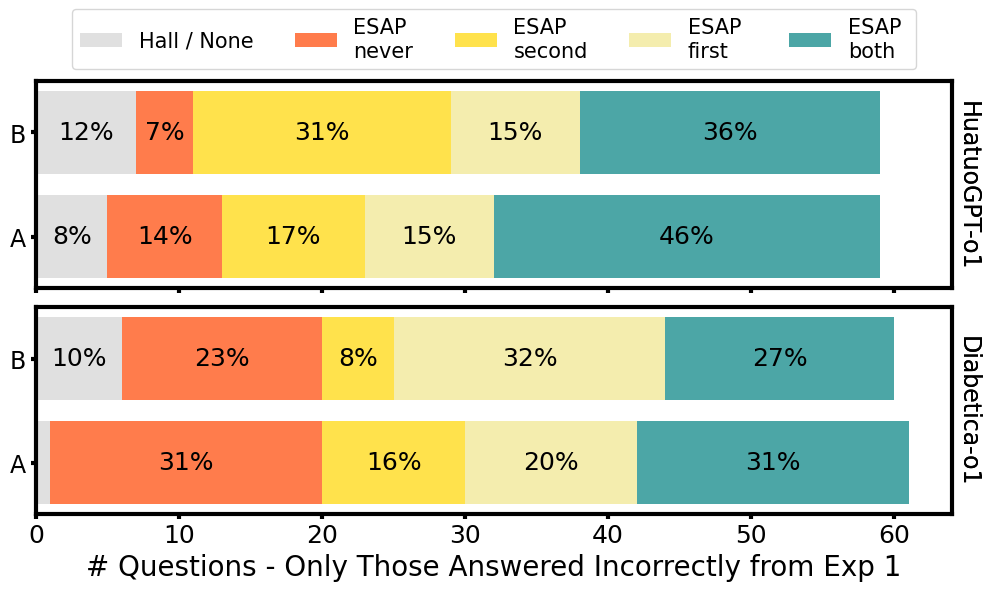

In [60]:
# Labels for each group (model + prompt)
labels = ['A', 'B'] 

outcome = ["Hall / None",
           "ESAP \nnever",
           "ESAP \nsecond",
           "ESAP \nfirst",
           "ESAP \nboth"
]

data_dict = {}
percentage_dict = {}

for model_name in dict_fileid:
    data_dict[model_name] = []
    percentage_dict[model_name] = []
    
    for prompt in dict_fileid[model_name]:
        tmp_data = np.append(missing_choice[model_name][prompt], 
                             np.ravel(contingency_table_dict[model_name][prompt].values))
        data_dict[model_name].append(tmp_data)
        percentage_dict[model_name].append(tmp_data / tmp_data.sum())

    data_dict[model_name] = np.array(data_dict[model_name])
    percentage_dict[model_name] = 100 * np.array(percentage_dict[model_name])

# Define outcome colors (5 outcomes)
colors = ['lightgray', 'orangered', 'gold', 'khaki', 'teal'] #  

# Create plot
nrows = len(dict_fileid.keys())
fig, ax = plt.subplots(figsize=(10, 6), ncols=1, nrows=nrows, sharex=True)

for j_, model_name in enumerate(dict_fileid.keys()):

    ax[j_].spines['bottom'].set_linewidth(3)
    ax[j_].spines['left'].set_linewidth(3)
    ax[j_].spines['top'].set_linewidth(3)
    ax[j_].spines['right'].set_linewidth(3)
    ax[j_].tick_params(width=3)
    
    for k_, (percentage_, data_) in enumerate(zip(percentage_dict[model_name], data_dict[model_name])):

        left = 0
        for i in range(data_.size):  # for each outcome
            value = data_[i]
            perc = percentage_[i]
            if perc > 2:  #  skip annotation on short segments
                ax[j_].text(left + value / 2, k_, f"{perc:.0f}%", va='center', 
                                ha='center', fontsize=18, color='black')
            
            label = outcome[i] if (k_ == 0 and j_ == 0) else None
            
            ax[j_].barh(labels[k_], data_[i], left=left, color=colors[i], alpha=.7, 
                        label=label)
            left += data_[i]

        tick = ax[j_].yaxis.get_major_ticks()
        for t in tick:
            t.label1.set_fontsize(17) 
        
        ax2 = ax[j_].secondary_yaxis('right')
        
        ax2.set_ylabel(f"{model_file_name_dict[model_name]}", rotation=270, labelpad=20, fontsize=17)
        ax2.set_yticks([])
        ax2.tick_params(length=0)    # hide its ticks if you’d like

    tick = ax[1].xaxis.get_major_ticks()
    for t in tick:
        t.label1.set_fontsize(18) 

    # Add legend and labels
    ax[1].set_xlabel('# Questions - Only Those Answered Incorrectly from Exp 1', fontsize=20)
    # ax[1].set_xlim(0, 61)
    ax[0].legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', ncol=5, fontsize=15)

    plt.tight_layout()
    # plt.savefig("plots/model_re-eval_given_gt.pdf")
plt.show()

# Experiment 2: Repetitions

In [61]:
model_list = ['HuatuoGPT-o1-8B', 'Diabetica-o1', 'Diabetica-7B', 'Meditron3-8B']
model_file = ['huatuo-o1', 'diabetica-o1', 'diabetica-7B', 'meditron3-8B']
temperature_list = [0.3, 0.6, 1.]
path_repetitions = f"{path_to_results}/REPETITIONS"

The following comparison matrix contains the number of times the LLMs select the correct option. 

``rep_df`` is a Excel with 91 rows (cases) and 10 columns (repetitions).

We repeat this across the three temperatures tested.

In [62]:
def max_frequency_string(arr):
    """ This code returns nan if there is no majorty selected (e.g., two options with same
    frequency). Otherwise, option and how many times it was selected. """
    if not arr.size:
        return None, 0
    unique_elements, counts = np.unique(arr, return_counts=True)
    max_indexes = counts == np.max(counts)
    if np.sum(max_indexes) > 1:
        return np.nan, np.nan # returns not a number if we do not have a majority
    # elif unique_elements[np.argmax(counts)] not in options:
    #     return np.nan, np.nan # if max option is none
    else:
        return unique_elements[np.argmax(counts)], np.max(counts)

Counting outputs: There are some cases where models does not make a selection, we report these values as well.

In [63]:
# what is the accuracy for each run, model, temperature
bm_across_models_and_t = []
comparison_mat_all = []
most_sel_list_and_t = []
count_sel_list_and_t = []

for t_ in temperature_list:
    bm_across_models = []
    comparison_mat = []
    most_sel_list = []
    count_sel_list = []

    for m_ in model_file: 
        # for each model and temperature we load the excel and retrieve information
        rep_df = pd.read_excel(f"{path_repetitions}/T={t_}/{m_}/{m_}_promptID_001_repetitions.xlsx",
                               header=None, index_col=0)
        comparison = rep_df.eq(df_all['truth'], axis=0)
        
        most_sel = []
        count_sel = []
        for id_row, row in enumerate(rep_df.values):
            row = row[~pd.isna(row)]
            cat, count = max_frequency_string(row)
            most_sel.append(cat)
            count_sel.append(count)
        most_sel_list.append(np.array(most_sel))
        count_sel_list.append(np.array(count_sel))
        
        # how many times correct option selected across 10 runs
        comparison_mat.append(comparison.sum(axis=1).values) 
        
        # accuracy for each run
        bm_across_models.append(comparison.sum(axis=0).values) 
        
    most_sel_list_and_t.append(most_sel_list)
    count_sel_list_and_t.append(count_sel_list)
    comparison_mat_all.append(np.array(comparison_mat))
    bm_across_models_and_t.append(bm_across_models)
    
comparison_mat = np.array(comparison_mat_all)
most_sel_list_and_t = np.array(most_sel_list_and_t)
count_sel_list_and_t = np.array(count_sel_list_and_t)

indexes_questions = rep_df.index    

In [64]:
print(comparison_mat.shape) # accuracy (10/10 = 100%, 0/10 = 0%)
print(most_sel_list_and_t.shape) # majority vote
print(count_sel_list_and_t.shape) # frequency of majority vote

(3, 4, 91)
(3, 4, 91)
(3, 4, 91)


Saving the majority vote frequency:

In [65]:
unique_vals = np.unique(most_sel_list_and_t)
count_t_m = np.zeros((len(temperature_list), len(model_list), len(unique_vals)), dtype=int)
list_df = []
for id_t, t in enumerate(temperature_list):
    for id_m, m in enumerate(model_list):
        for id_v, v_ in enumerate(unique_vals):
            count_t_m[id_t, id_m, id_v] = np.sum(most_sel_list_and_t[id_t, id_m] == v_)
    majority_vote_ = pd.DataFrame(index=model_list, columns=unique_vals, data=count_t_m[id_t])
    majority_vote_.to_latex(f"tables/majority_vote_T={t}.tex")

In [66]:
majority_vote_

,A,B,C,D,E,NONE,nan
HuatuoGPT-o1-8B,17,23,20,15,11,0,5
Diabetica-o1,13,19,25,16,8,0,10
Diabetica-7B,14,19,26,15,11,0,6
Meditron3-8B,3,4,0,2,2,72,8


Below, dataframes one per temperature, containing number of correct responses across runs (row) and models (column):

In [67]:
# this is a list of dataframes, one per temperature
df_accuracy_runs_list = [pd.DataFrame(bm_models_, index=model_list, columns=np.arange(1,11)).T 
                         for bm_models_ in bm_across_models_and_t]

In [68]:
df_accuracy_runs_list[0]

,HuatuoGPT-o1-8B,Diabetica-o1,Diabetica-7B,Meditron3-8B
1,32,33,27,27
2,38,29,29,32
3,28,31,27,29
4,32,29,26,31
5,32,29,28,25
6,30,29,24,26
7,34,27,32,35
8,37,29,27,33
9,32,28,30,27
10,35,31,21,24


In [69]:
# Report hallucination for each model

counting_outputs = []
index = []

for t_ in temperature_list:
    for m_ in model_file: 
        filepath = f"{path_repetitions}/T={t_}/{m_}/{m_}_promptID_001_repetitions.xlsx"
        dct_counter = evaluate_response_distrib(filepath)
        
        index.append(f"T={t_} m={m_}")
        counting_outputs.append([dct_counter[k] for k in sorted(dct_counter.keys())])
columns_name = sorted(dct_counter.keys())

df_counter = pd.DataFrame(data=counting_outputs, 
                          index=index,
                          columns=columns_name)
df_counter.to_latex("tables/readability_experiment2.tex")
df_counter

['A' 'B' 'B-E' 'B-E-A' 'C' 'D' 'E' 'HALL']
['A' 'B' 'C' 'D' 'E']
['A' 'B' 'B-E' 'C' 'C-D' 'D' 'E' 'NONE']
['A' 'B' 'B-C' 'C' 'D' 'E' 'HALL' 'NONE']
['A' 'B' 'C' 'D' 'E' 'HALL']
['A' 'B' 'C' 'D' 'E' 'HALL' 'NONE']
['A' 'A-B' 'B' 'C' 'D' 'E' 'HALL' 'NONE']
['A' 'B' 'C' 'D' 'E' 'HALL' 'NONE']
['A' 'B' 'B-E' 'C' 'D' 'D-A' 'E' 'HALL' 'NONE']
['A' 'A-C' 'A-E' 'B' 'B-E' 'C' 'D' 'D-E' 'E' 'E-A' 'HALL' 'NONE']
['A' 'A-E' 'B' 'B-C' 'C' 'C-D' 'D' 'D-E' 'E' 'HALL' 'NONE' 'NONE-HALL']
['A' 'A-B' 'A-D' 'B' 'B-C' 'B-E' 'C' 'C-B' 'C-D' 'D' 'E' 'HALL' 'NONE']


,A,B,C,CHECK,D,E,HALL / NONE,MULTI,TOTAL
T=0.3 m=huatuo-o1,172,236,206,0,168,120,5,3,910
T=0.3 m=diabetica-o1,203,210,219,0,172,106,0,0,910
T=0.3 m=diabetica-7B,146,170,276,0,194,113,8,3,910
T=0.3 m=meditron3-8B,127,195,202,0,195,164,26,1,910
T=0.6 m=huatuo-o1,171,231,201,0,171,124,12,0,910
T=0.6 m=diabetica-o1,204,210,215,0,173,97,11,0,910
T=0.6 m=diabetica-7B,170,166,252,0,198,110,12,2,910
T=0.6 m=meditron3-8B,149,202,182,0,182,156,39,0,910
T=1.0 m=huatuo-o1,171,234,196,0,170,120,17,2,910
T=1.0 m=diabetica-o1,181,213,224,0,175,98,12,7,910


In [70]:
def plot_singular_responses(matrix_comparison, 
                            across_models=True, 
                            temp_id=1, 
                            model_id=None,
                            saveplot=False,
                            plotname=None):
    # temp 0 - 0.3, temp 1 - 0.6, temp 2 - 1.
    colors_palette = [
    "#b2182b",  # 0 - deep red
    "#d6604d",  # 1 - red-orange
    "#f4a582",  # 2 - orange
    "#fddbc7",  # 3 - light orange
    "#fee8c8",  # 4 - beige
    "#f7f7f7",  # 5 - white/neutral
    "#d1e5f0",  # 6 - very light blue
    "#92c5de",  # 7 - light blue
    "#4393c3",  # 8 - medium blue
    "#2166ac",  # 9 - dark blue
    "#053061",  # 10 - deepest blue
    ]
    
    fig, ax = plt.subplots(figsize=(30, 7))
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(width=2)
    
    if across_models: 
        sorted_id_answer = np.argsort(comparison_mat[temp_id][0]) # temperature 0.6, sorted by Huatuo
        matrix_to_iter = comparison_mat[temp_id]
        ylabel = model_list
        plt.title(f"LLMs at T={temperature_list[temp_id]}", fontsize=40, y=1.4)
        
    else: 
        sorted_id_answer = np.argsort(comparison_mat[0, model_id]) # temperature 0.6, sorted by Huatuo
        matrix_to_iter = comparison_mat[:, model_id]
        ylabel = temperature_list
        ax.set_ylabel("Temperature", fontsize=25)
        plt.title(f"{model_list[model_id]} at Different Temperatures", fontsize=40, y=1.4)

    n_bars = matrix_to_iter.shape[0]

    for i_iterator, votes_model in enumerate(matrix_to_iter):
        votes_model = votes_model[sorted_id_answer]
        for j, val in enumerate(votes_model):
            ax.barh(i_iterator, width=1, left=j, color=colors_palette[val], edgecolor='black')
            
    sorted_labs = meta_labs_tab_df['labs'].values[sorted_id_answer]
    for i_counter, l_ in enumerate(sorted_labs):
        if l_:
            color = 'white'
        else:
            color = 'lightgray'
        ax.barh(matrix_to_iter.shape[0], width=1, left=i_counter, color=color, edgecolor='black')

    # Set y-axis labels
    ax.set_yticks(range(n_bars + 1))
    ax.set_yticklabels(ylabel + ["Lab Tests"], rotation=0, fontsize=12)

    # Add legend for shades
    from matplotlib.patches import Patch
    
    text_legend = list(np.arange(11).astype(str)) + ['Yes', 'No']
    colors_palette_all = colors_palette + ['white', 'lightgray']
    legend_labels = [Patch(facecolor=colors_palette_all[i], label=f'{val}', edgecolor='black') 
                     for i, val in enumerate(text_legend)]
    
    ax.legend(handles=legend_labels, title='# Times Correct Option is Selected', 
              bbox_to_anchor=(0.5, 1.4), loc='upper center',
              ncol=13, fontsize=25, title_fontsize=25
              )

    ax.set_xticks(np.arange(len(sorted_id_answer))+0.5, 
                  indexes_questions[sorted_id_answer]);

    
    tick = ax.yaxis.get_major_ticks()
    for t in tick:
        t.label1.set_fontsize(25) 

    tick = ax.xaxis.get_major_ticks()
    for t in tick:
        t.label1.set_fontsize(13) 

    plt.xlabel("Case ID", fontsize=30)
    
    plt.tight_layout()
    if saveplot:
        plt.savefig(plotname)
    plt.show()

In [86]:
temperature_list

[0.3, 0.6, 1.0]

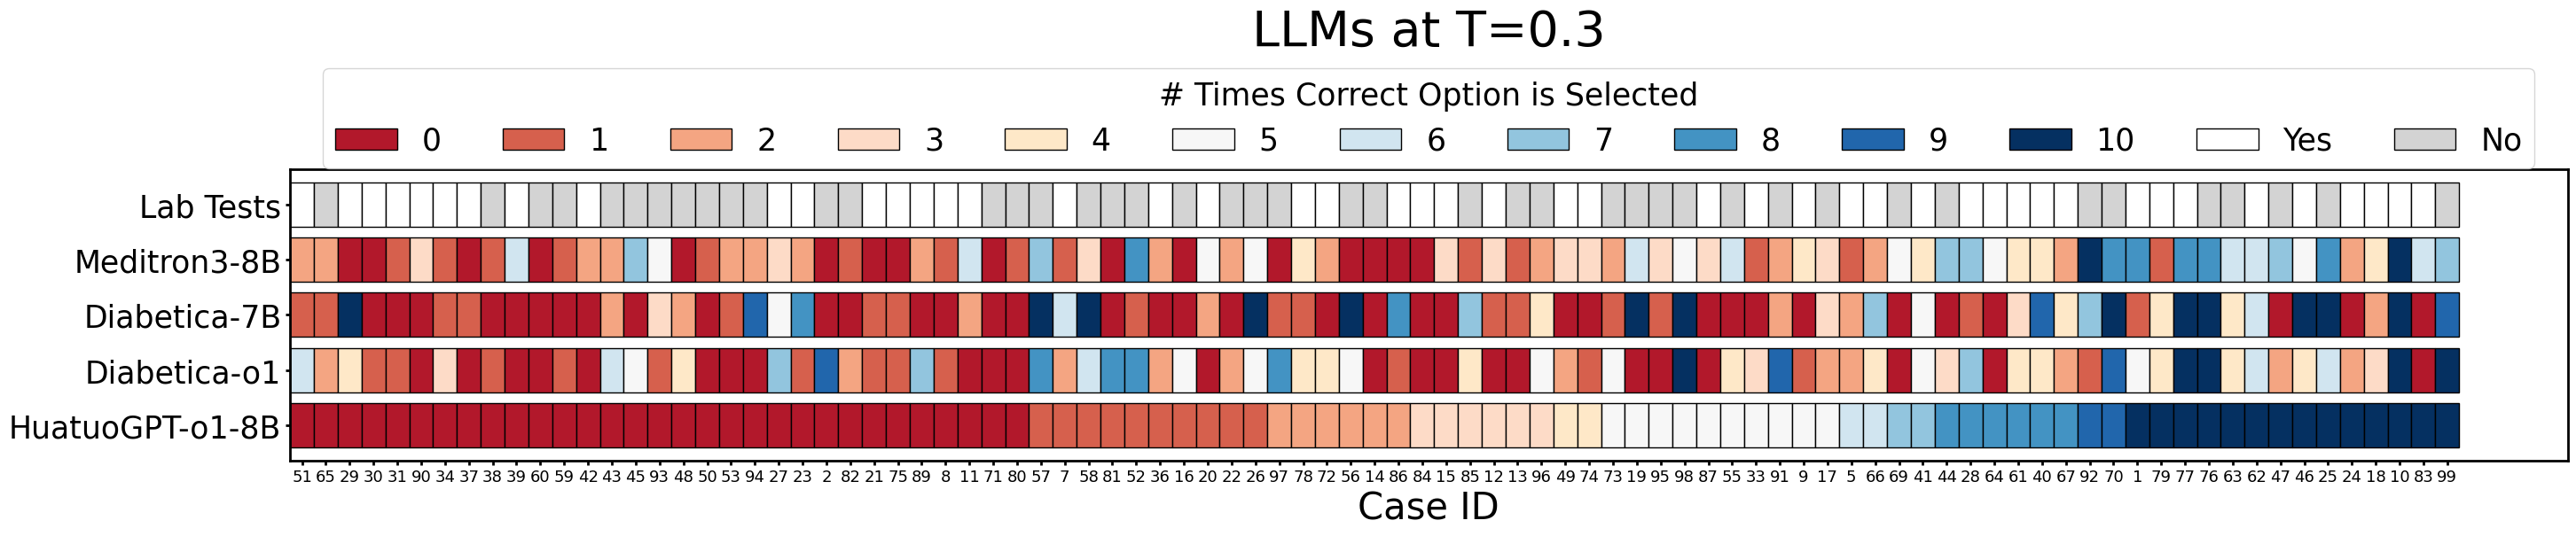

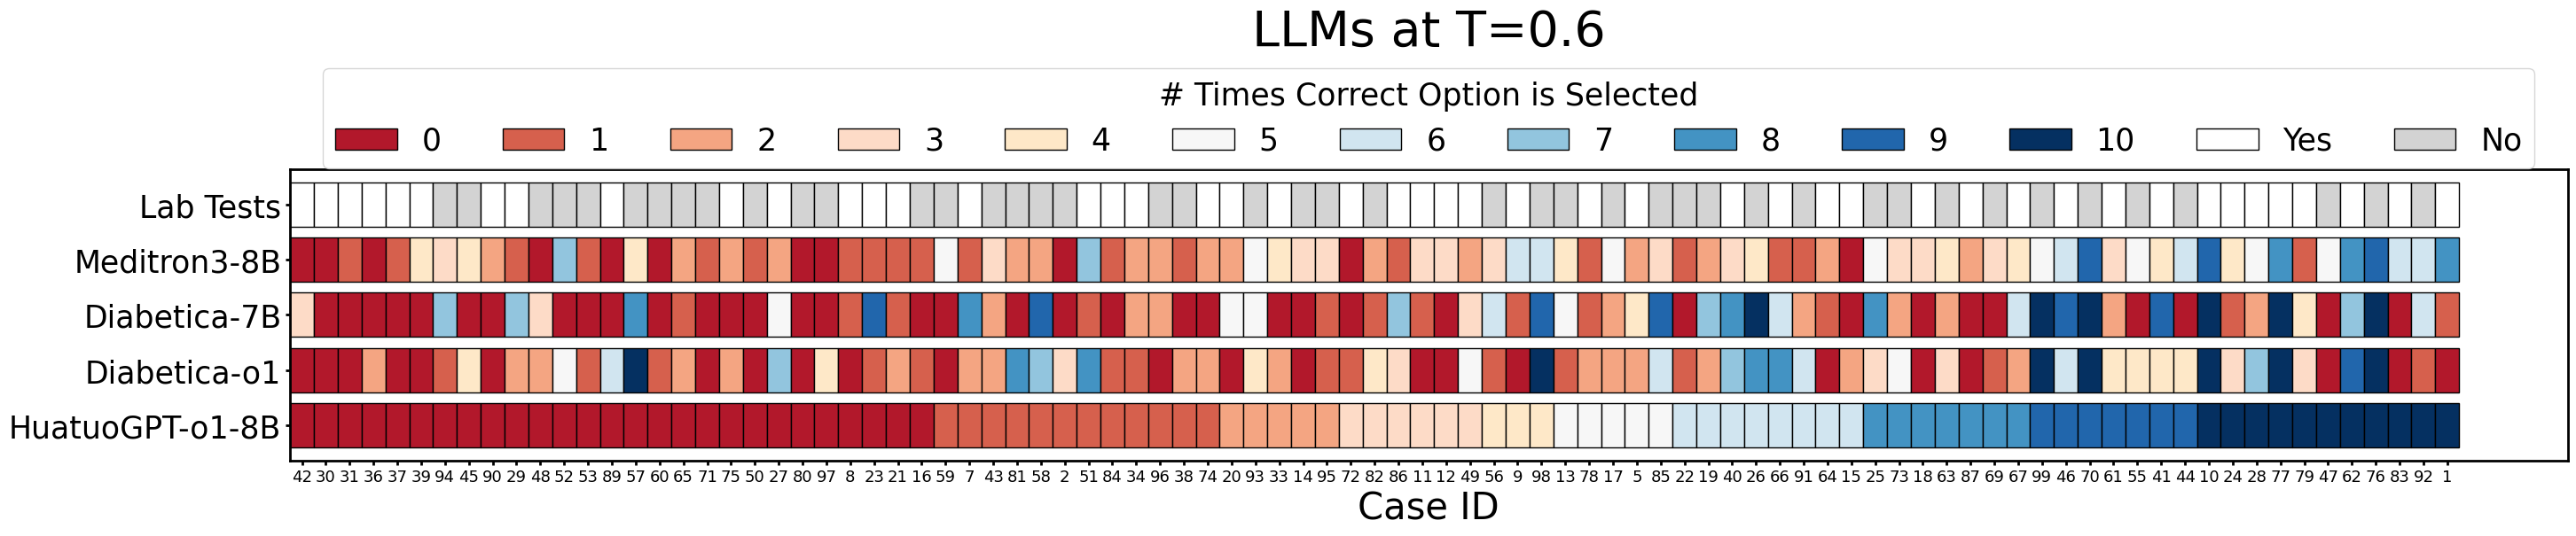

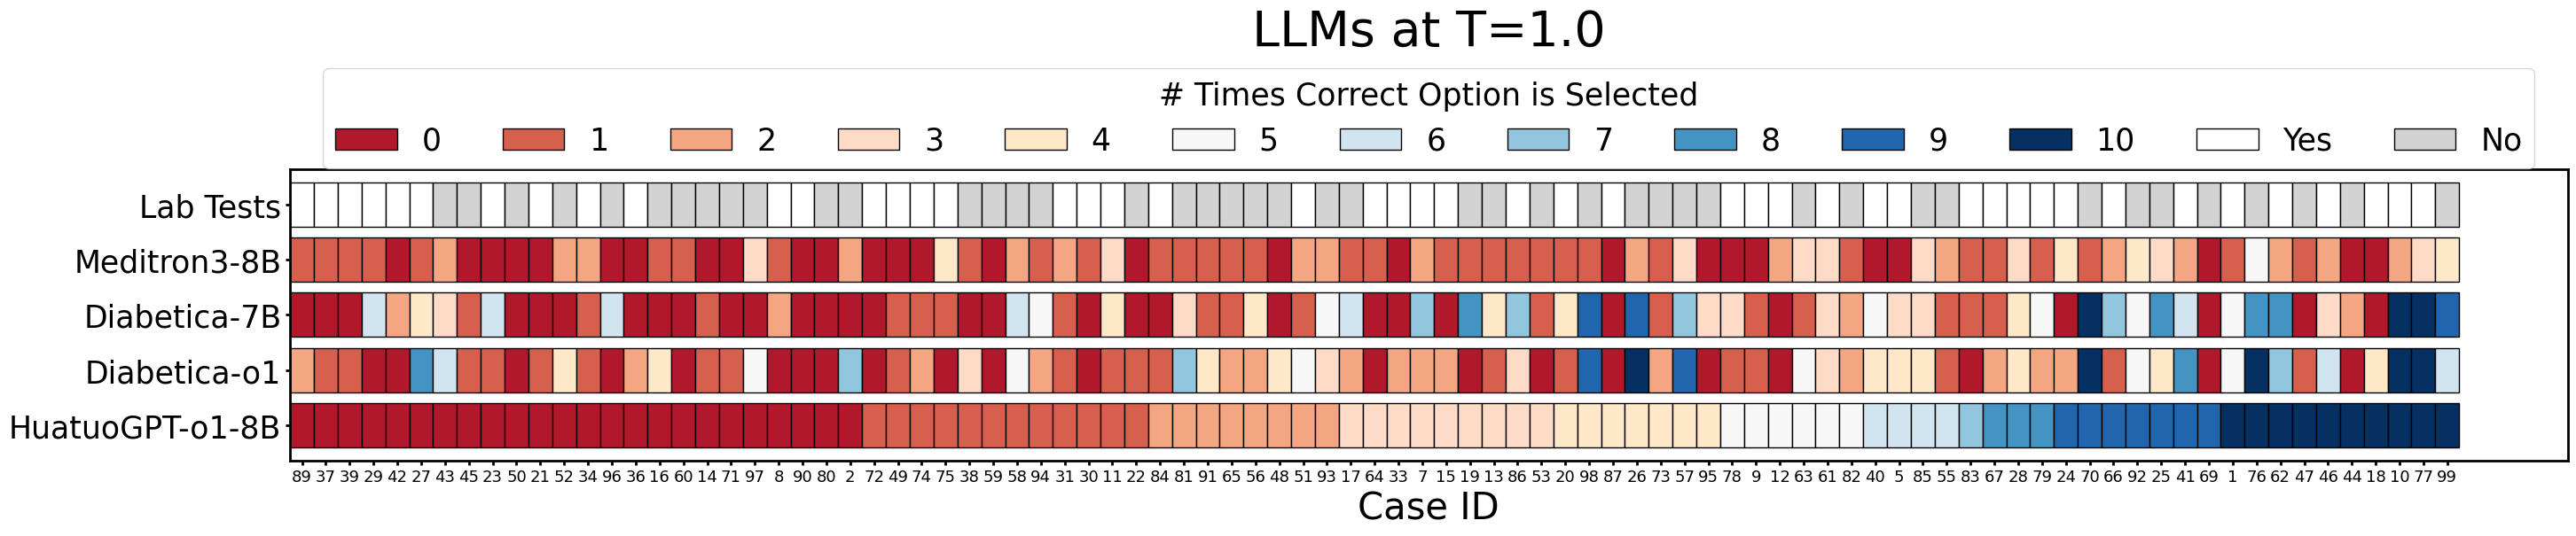

In [71]:
for id_t, t_ in enumerate(temperature_list):
    plotname = f"plots/responses_exp2_extensive_T={t_}.pdf"

    plot_singular_responses(comparison_mat, 
                            across_models=True, 
                            temp_id=id_t, 
                            model_id=None,
                            saveplot=False,
                            plotname=plotname)

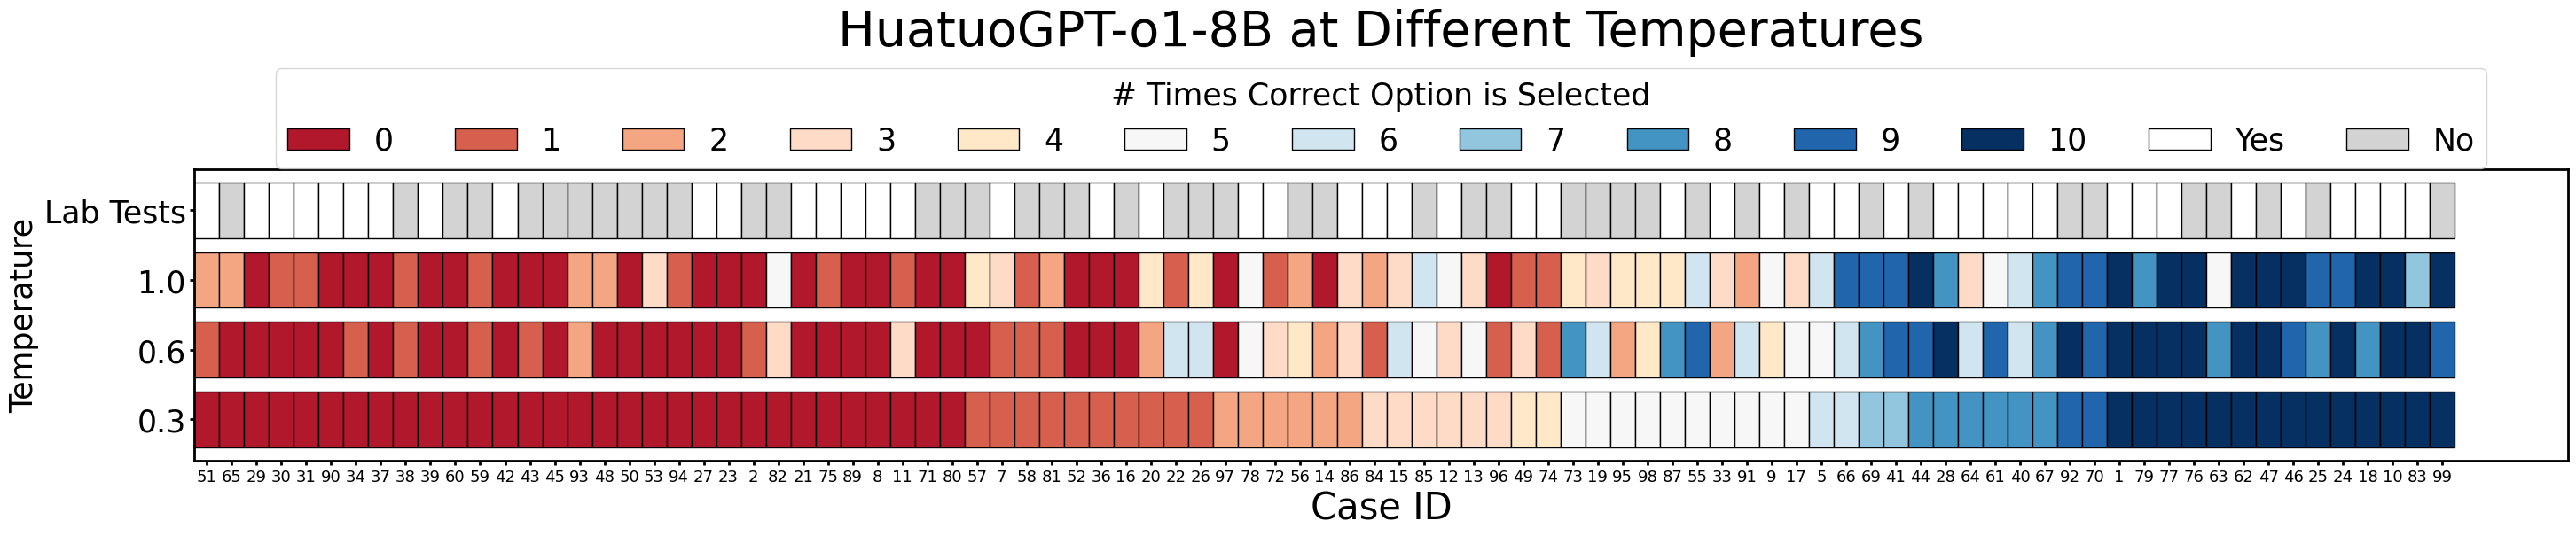

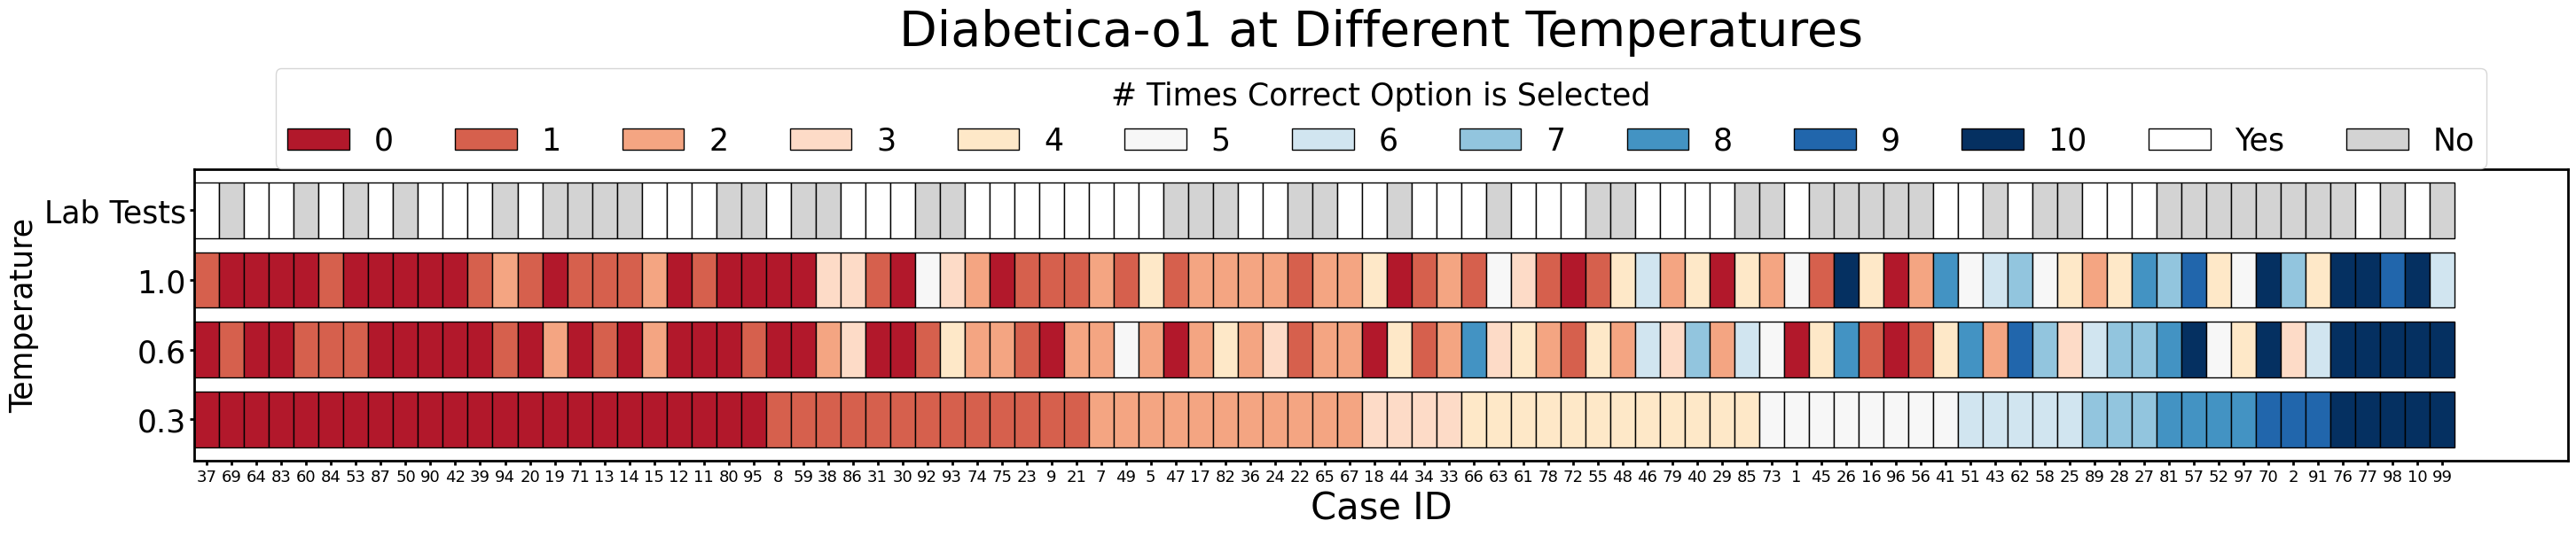

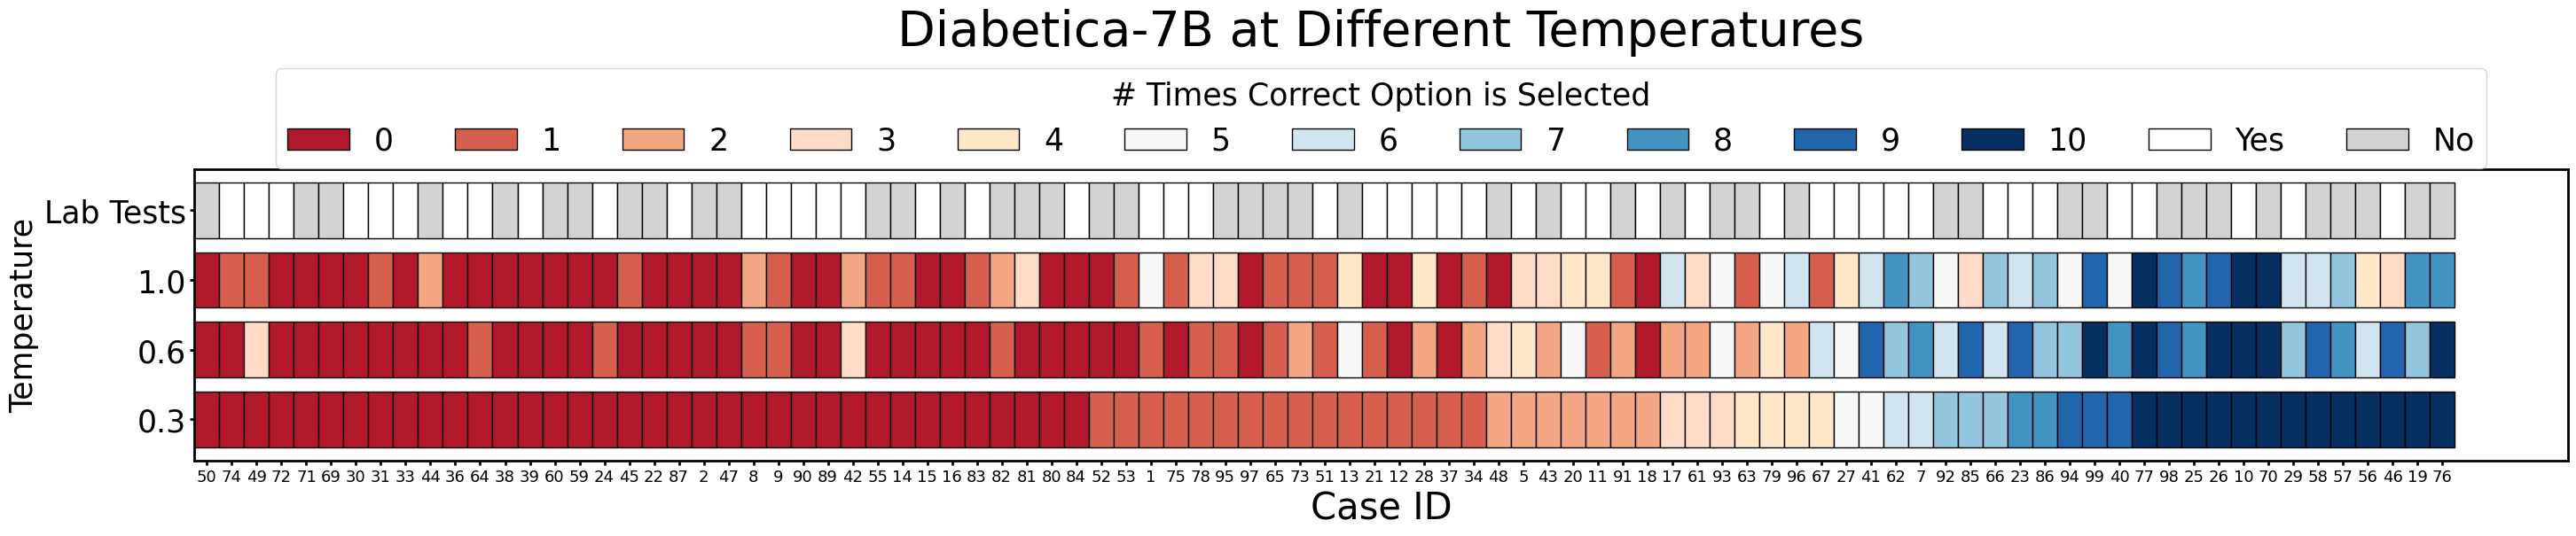

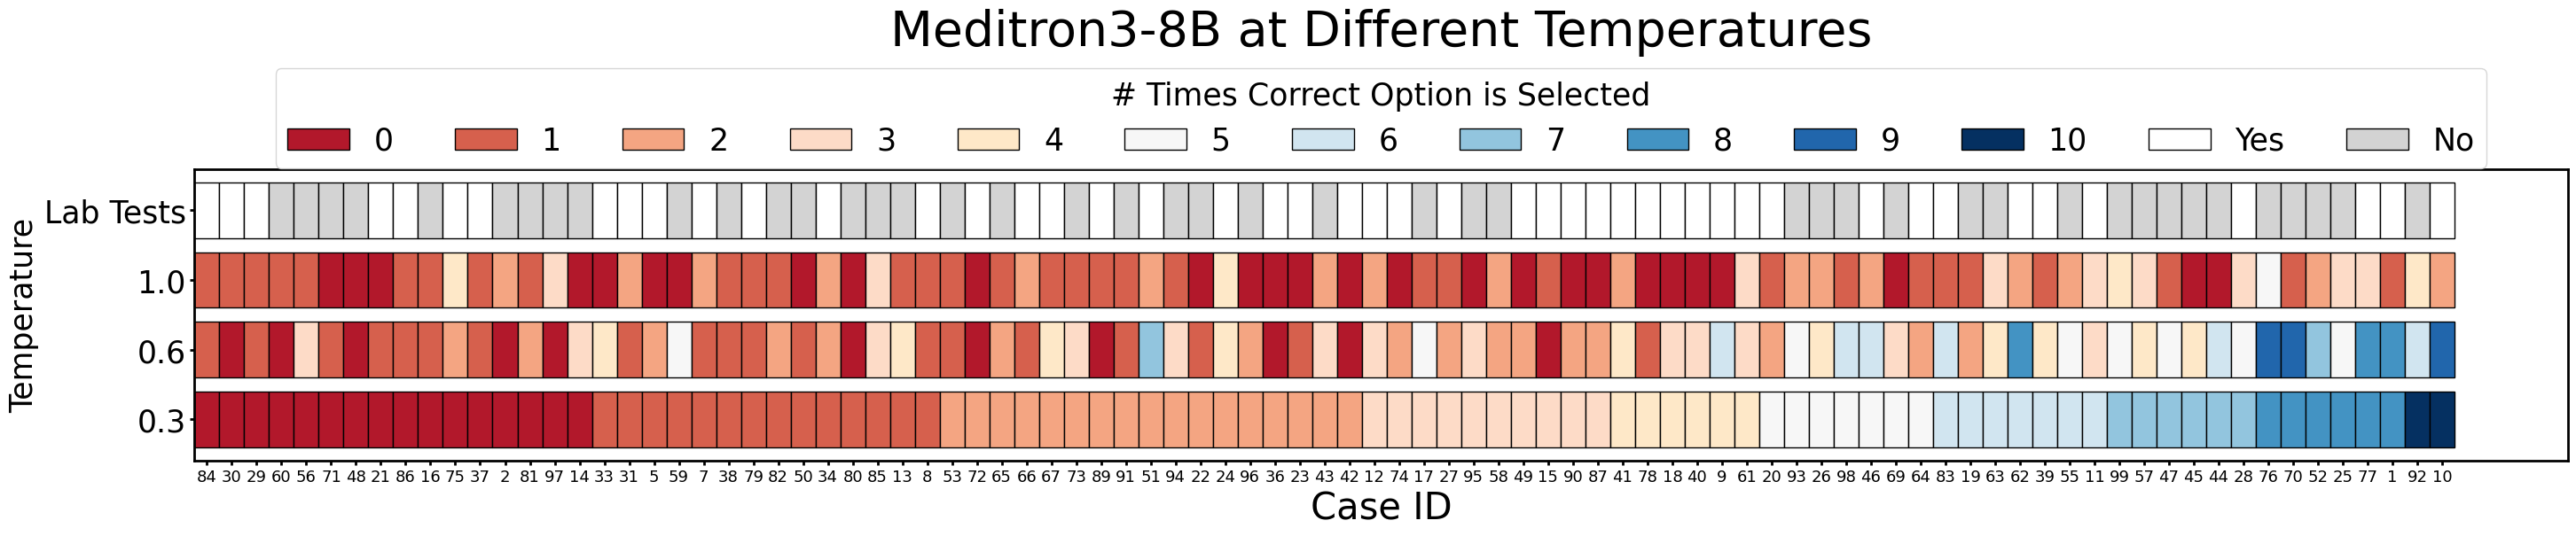

In [72]:
for id_m, m_ in enumerate(model_list):
    plotname = f"plots/responses_exp2_extensive_m={m_}.pdf"

    plot_singular_responses(comparison_mat, across_models=False, model_id=id_m,
                            saveplot=False, plotname=plotname)

In [89]:
# plot_singular_responses(comparison_mat, across_models=True, temp_id=2, model_id=None)

In [90]:
# plot_singular_responses(comparison_mat, across_models=True, temp_id=1, model_id=0)

In [73]:
(comparison_mat[1][0] > comparison_mat[0][0]).sum()

np.int64(30)

In [74]:
(comparison_mat[2][0] > comparison_mat[0][0]).sum()

np.int64(27)

In [75]:
(comparison_mat[2][0] > comparison_mat[1][0]).sum()

np.int64(27)

In [76]:
comparison_mat.shape

(3, 4, 91)

In [77]:
(comparison_mat[0][0] > comparison_mat[2][0]).sum()

np.int64(26)

In [78]:
# NEW: huatuo-o1 correctness over others
t_ = 2

np.logical_and(np.logical_and(comparison_mat[t_][0] >= comparison_mat[t_][1], 
                              comparison_mat[t_][0] >= comparison_mat[t_][3]),
              comparison_mat[t_][0] >= comparison_mat[t_][2]).sum()

np.int64(48)

In [79]:
# NEW: diabetica-o1 correctness over others

np.logical_and(np.logical_and(comparison_mat[t_][1] >= comparison_mat[t_][0],
                              comparison_mat[t_][1] >= comparison_mat[t_][3]),
               comparison_mat[t_][1] >= comparison_mat[t_][2]).sum()

np.int64(34)

In [80]:
comparison_mat.shape

(3, 4, 91)

In [81]:
# times meditron3 8B superior to huatuo-o1 and diabetica-o1

np.logical_and(comparison_mat[1][3] >= comparison_mat[1][0],
               comparison_mat[1][3] >= comparison_mat[1][1]).sum()

np.int64(33)

In [82]:
# NEW: meditron3-8B correctness over others

np.logical_and(np.logical_and(comparison_mat[1][3] >= comparison_mat[1][0],
                              comparison_mat[1][3] >= comparison_mat[1][1]),
               comparison_mat[1][3] >= comparison_mat[1][2]).sum()

np.int64(29)

In [83]:
# NEW: diabetica-7B correctness over others

np.logical_and(np.logical_and(comparison_mat[1][2] >= comparison_mat[1][0],
                              comparison_mat[1][2] >= comparison_mat[1][1]),
               comparison_mat[1][2] >= comparison_mat[1][3]).sum()

np.int64(29)

In [84]:
# huatuo-o1 equivalent or better

(np.argmax(comparison_mat, axis=0)==0).sum()

np.int64(206)

In [85]:
vals= pd.DataFrame(comparison_mat[0], index=model_list,
                   columns=df_all['truth'].index)

In [86]:
vals

,1,2,5,7,8,9,10,11,12,13,...,90,91,92,93,94,95,96,97,98,99
HuatuoGPT-o1-8B,10,0,6,1,0,5,10,0,3,3,...,0,5,9,0,0,5,3,2,5,10
Diabetica-o1,5,9,2,2,1,1,10,0,0,0,...,0,9,1,1,0,0,5,8,10,10
Diabetica-7B,1,0,2,6,0,0,10,2,1,1,...,0,2,7,3,9,1,4,1,10,9
Meditron3-8B,8,0,1,1,1,4,10,6,3,1,...,3,2,10,5,2,3,2,0,5,7


In [87]:
comparison_mat.shape

(3, 4, 91)

In [88]:
vals

,1,2,5,7,8,9,10,11,12,13,...,90,91,92,93,94,95,96,97,98,99
HuatuoGPT-o1-8B,10,0,6,1,0,5,10,0,3,3,...,0,5,9,0,0,5,3,2,5,10
Diabetica-o1,5,9,2,2,1,1,10,0,0,0,...,0,9,1,1,0,0,5,8,10,10
Diabetica-7B,1,0,2,6,0,0,10,2,1,1,...,0,2,7,3,9,1,4,1,10,9
Meditron3-8B,8,0,1,1,1,4,10,6,3,1,...,3,2,10,5,2,3,2,0,5,7


In [89]:
(vals==0).sum(axis=1) # how many times the model never gets the right answer

HuatuoGPT-o1-8B    31
Diabetica-o1       23
Diabetica-7B       36
Meditron3-8B       16
dtype: int64

In [90]:
# Define the full range of expected values
possible_values = list(range(0, 11))

# Count values row-wise
counts_per_row = vals.apply(lambda row: row.value_counts().reindex(possible_values, fill_value=0), axis=1)

counts_per_row = counts_per_row.T

In [91]:
counts_per_row

,HuatuoGPT-o1-8B,Diabetica-o1,Diabetica-7B,Meditron3-8B
0,31,23,36,16
1,10,13,16,14
2,6,11,7,17
3,6,4,3,10
4,2,12,4,6
5,10,8,2,7
6,2,5,2,7
7,2,3,3,6
8,6,4,2,6
9,2,3,3,0


In [92]:
# counts_per_row.to_latex("T=1_table_repetitions_summary.tex")

In [93]:
counts_per_col = counts_per_row.T

counts_per_col

# counts_per_col.to_latex("tables/NEW_table_repetitions_summary.tex")

,0,1,2,3,4,5,6,7,8,9,10
HuatuoGPT-o1-8B,31,10,6,6,2,10,2,2,6,2,14
Diabetica-o1,23,13,11,4,12,8,5,3,4,3,5
Diabetica-7B,36,16,7,3,4,2,2,3,2,3,13
Meditron3-8B,16,14,17,10,6,7,7,6,6,0,2


In [94]:
counts_per_col.sum(axis=1) # sanity check

HuatuoGPT-o1-8B    91
Diabetica-o1       91
Diabetica-7B       91
Meditron3-8B       91
dtype: int64

In [95]:
for id_t, t_ in enumerate(temperature_list):
    result = -np.ones((len(model_file), 2), dtype=int)
    for id_m, m_ in enumerate(model_file): 
        idx_correct_10 = np.where(comparison_mat[id_t][id_m] == 10)[0]
        n_correct_10 = idx_correct_10.size
        n_consist_10 = np.where(count_sel_list_and_t[id_t][id_m] == 10)[0].size 
        result[id_m, :] = np.array([n_correct_10, n_consist_10 - n_correct_10])
    correct_consist = pd.DataFrame(index=model_list, 
                                   columns=["# correct 10 times", "# consistently incorrect 10 times"], 
                                   data=result)
    # correct_consist.to_latex(f"tables/correct_consistent_T={t_}.tex")


# Heatmaps and representations

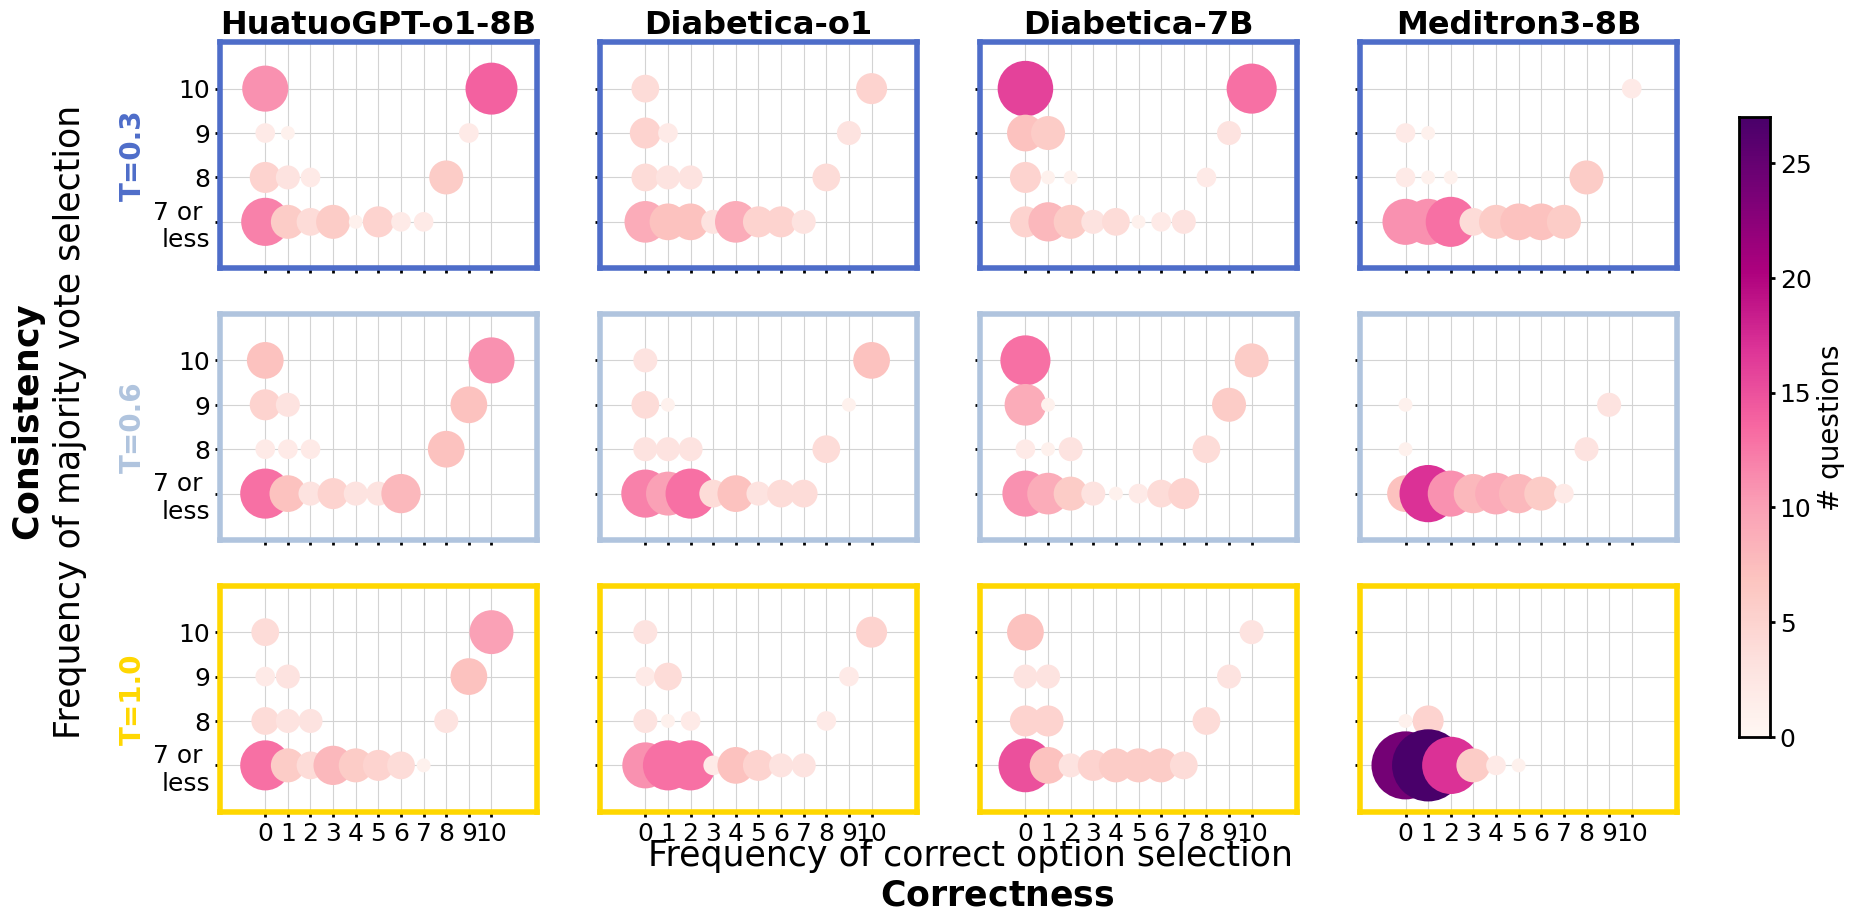

In [96]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=3, ncols=4, sharex=True, sharey=True)
row_colors = ['#bbbbbb', '#777777', '#000000']  # or use more steps if needed
row_colors = [
    (0.3060, 0.4285, 0.7891),
    'lightsteelblue',
    'gold'
]

global_max = 0
for i_t, t in enumerate(temperature_list):
    for i_m in range(len(model_list)):
        data_heatmap = np.zeros((8, 11))
        bm_majority = ~np.isnan(count_sel_list_and_t[i_t][i_m])
        for consistency, correctness in zip(count_sel_list_and_t[i_t][i_m][bm_majority],
                                            comparison_mat[i_t][i_m][bm_majority]):
            data_heatmap[int(consistency)-3, int(correctness)] += 1
        data_heatmap = np.vstack((data_heatmap[:5,:].sum(axis=0).reshape(1,-1), 
                                  data_heatmap[5:,:]))
        tmp_max = np.max(data_heatmap) # check, I think it is wrong
        # print(tmp_max)
        if tmp_max > global_max:
            global_max = tmp_max

                
for i_t, t in enumerate(temperature_list):
    df_heatmap_list = []
    
    for i_m in range(len(model_list)):

        data_heatmap = np.zeros((8, 11))
        bm_majority = ~np.isnan(count_sel_list_and_t[i_t][i_m]) # there is a majority

        for consistency, correctness in zip(count_sel_list_and_t[i_t][i_m][bm_majority], # count of majority vote
                                            comparison_mat[i_t][i_m][bm_majority]): # count of correct class

            data_heatmap[int(consistency)-3, int(correctness)] += 1
            
        data_heatmap = np.vstack((data_heatmap[:5,:].sum(axis=0).reshape(1,-1), 
                                  data_heatmap[5:,:]))
        data_heatmap = data_heatmap[::-1]
        data = pd.DataFrame(data_heatmap, columns=range(11),
                            index=[10, 9, 8, '7 or \nless'])

        ax[i_t, i_m].spines['bottom'].set_linewidth(4)
        ax[i_t, i_m].spines['left'].set_linewidth(4)
        ax[i_t, i_m].spines['top'].set_linewidth(4)
        ax[i_t, i_m].spines['right'].set_linewidth(4)
        ax[i_t, i_m].tick_params(width=2)

        for spine in ax[i_t, i_m].spines.values():
            spine.set_color(row_colors[i_t])
            
        x_labels = data.columns
        y_labels = data.index
        x_pos, y_pos, sizes, texts = [], [], [], []
        ax[i_t, i_m].grid(True, color='lightgray')
        
        for i, y in enumerate(y_labels):
            for j, x in enumerate(x_labels):
                val = int(data.iloc[i, j])
                if val > 0:
                    x_pos.append(j)
                    y_pos.append(i)
                    sizes.append(val * 100)  # adjust scale
                    texts.append(str(val))

        scatter = ax[i_t, i_m].scatter(
            x_pos, y_pos,
            s=sizes, 
            c=[int(t) for t in texts],  # values to color by
            cmap="RdPu", 
            edgecolors='none', 
            marker='o', 
            zorder=4,
            vmin=0, 
            vmax=global_max,
            # cmap='viridis'  # filled blobs
        )

        # Add number labels to each blob
        # for (x, y, t) in zip(x_pos, y_pos, texts):
        #    ax[i_t, i_m].text(x, y, t, color='black', ha='center', va='center', fontsize=12, zorder=5)

        # === Ticks and labels ===
        ax[i_t, i_m].margins(x=0.2, y=0.35)  # add 10% padding on both axes
        ax[i_t, i_m].set_xticks(range(len(x_labels)))
        ax[i_t, i_m].set_xticklabels(x_labels, fontsize=18)
        ax[i_t, i_m].set_yticks(range(len(y_labels)))
        ax[i_t, i_m].set_yticklabels(y_labels, fontsize=18)
        ax[0, i_m].set_title(model_list[i_m], fontsize=23, weight='bold')
       
    ax[i_t, 0].set_ylabel(f"T={t}", fontsize=20, weight='bold', color=row_colors[i_t], 
                          # rotation='horizontal'
                         )
    fig.supxlabel('Frequency of correct option selection\n     $\\bf{Correctness}$', fontsize=25)
    fig.supylabel('                  $\\bf{Consistency}$\nFrequency of majority vote selection', fontsize=25)

ax[0, 0].invert_yaxis()  # match heatmap orientation

sm = cm.ScalarMappable(cmap='RdPu', norm=plt.Normalize(vmin=0, vmax=global_max))
sm.set_array([])  # required dummy array

# Add colorbar to the figure
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('# questions', fontsize=20)
for spine in cbar.ax.spines.values():
    spine.set_visible(True)
cbar.ax.tick_params(labelsize=18, width=2)
cbar.ax.spines['bottom'].set_linewidth(2)
cbar.ax.spines['left'].set_linewidth(2)
cbar.ax.spines['top'].set_linewidth(2)
cbar.ax.spines['right'].set_linewidth(2)

# plt.tight_layout()
# plt.savefig("plots/correctness_consistency.pdf")
plt.show()

# Answers Correctness Across Runs at Different Temperatures

Number of correct responses across each run.

In [97]:
results

,# correct,# interpretable
meditron3-8B-prompt1,30,89
huatuo-o1-prompt1,32,91
huatuo-o1-prompt2,32,91
diabetica-o1-prompt1,30,91
diabetica-o1-prompt2,31,91
diabetica-7B-prompt1,27,90
diabetica-7B-prompt2,29,91
medfound7B-prompt1,4,17
medfound7B-prompt2,11,35
clinical-chatgpt-prompt1,18,72


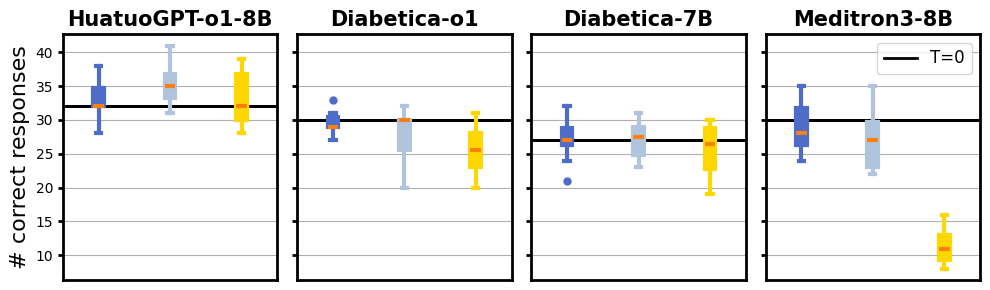

In [98]:
fig, ax = plt.subplots(figsize=(10,3), ncols=len(model_list), sharey=True)

boxprops = dict(linewidth=3)
medianprops = dict(linewidth=3)
whiskerprops = dict(linewidth=3)
capprops = dict(linewidth=3)
flierprops = dict(marker='o', markersize=5, linestyle='none')

color_t0 = 'black'
colors_list = [
    (0.3060, 0.4285, 0.7891),
    'lightsteelblue',
    'gold'
]


for j, t in enumerate(temperature_list): 
    # each temperature has a different color
    box_color = colors_list[j]

    for i, (m, m_name) in enumerate(zip(model_file, model_list)):
        ax[i].spines['bottom'].set_linewidth(2)
        ax[i].spines['left'].set_linewidth(2)
        ax[i].spines['top'].set_linewidth(2)
        ax[i].spines['right'].set_linewidth(2)
        ax[i].tick_params(width=2)
        ax[i].grid()

        lab = "T=0" if (i == 3 and j == 2) else None
        ax[i].axhline(results.loc[f"{m}-prompt1"]['# correct'], color=color_t0,
                          linewidth=2, linestyle='-', label=lab, zorder=2)

        flierprops = dict(marker='o', markersize=5, linestyle='none', 
                          markerfacecolor=box_color, markeredgecolor=box_color)

        bp = ax[i].boxplot(bm_across_models_and_t[j][i], 
                           positions=[j],
                           boxprops=boxprops, 
                           medianprops=medianprops,
                           whiskerprops=whiskerprops, 
                           capprops=capprops, 
                           flierprops=flierprops,
                           patch_artist=True, 
                           tick_labels=None,
                           # legend=lab,
                           zorder=4)
                
        bp['boxes'][0].set_facecolor(box_color)
        for element in ['boxes', 'whiskers', 'caps']: #, 'medians']:
            for b in bp[element]:
                b.set_color(box_color)
                b.set_linewidth(3)
        
        if t == temperature_list[-1]:
            ax[i].set_title(m_name, fontsize=15, weight='bold')
        ax[i].set_xticks([])          # removes tick locations
        ax[i].set_xticklabels([])     # removes labels (just in case)


tick = ax[0].yaxis.get_major_ticks()
# for t in tick:
#    t.label.set_fontsize(11) 
ax[0].set_ylabel("# correct responses", fontsize=16)

# legend
line_T0 = mlines.Line2D([], [], color='black', label='T=0')
# box_handles = [
#    mpatches.Patch(facecolor=color, edgecolor=color, label=f'T={temperature_list[k]}')
#    for k, color in enumerate(colors_list)]
# handles = line_T0 # [line_T0]  + box_handles
# ax[-1].legend(handles=handles, fontsize='large') #, loc='center left', bbox_to_anchor=(1, 0.5))
ax[-1].legend(fontsize='large')

plt.tight_layout()
# plt.savefig(f"plots/temperatures_distribution_runs.pdf")

In [119]:
for df_ in df_accuracy_runs_list:
    print(df_.describe())
    standard_error = df_.sem()
    # Calculate the confidence interval
    confidence_interval = st.t.interval(0.95, 91 - 1, loc=df_.mean(), scale=standard_error)
    print("Confidence Intervals:")
    print(confidence_interval)
    print("\n")

       HuatuoGPT-o1-8B  Diabetica-o1  Diabetica-7B  Meditron3-8B
count         10.00000     10.000000     10.000000     10.000000
mean          33.00000     29.500000     27.100000     28.900000
std            3.05505      1.715938      3.071373      3.695342
min           28.00000     27.000000     21.000000     24.000000
25%           32.00000     29.000000     26.250000     26.250000
50%           32.00000     29.000000     27.000000     28.000000
75%           34.75000     30.500000     28.750000     31.750000
max           38.00000     33.000000     32.000000     35.000000
Confidence Intervals:
(array([31.08069005, 28.42197605, 25.17043543, 26.57843198]), array([34.91930995, 30.57802395, 29.02956457, 31.22156802]))


       HuatuoGPT-o1-8B  Diabetica-o1  Diabetica-7B  Meditron3-8B
count        10.000000     10.000000     10.000000     10.000000
mean         35.400000     27.600000     27.200000     27.100000
std           3.238655      4.247875      2.740641      4.748099
min     